# <center> Projet 7: Implémentez un modèle de Scoring</center>

+ ## Partie 2: Modélisation

+ ### Bibliothèques

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os,joblib
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
from jupyterStyle import StyleHelper
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
import plotly.tools as tls
offline.init_notebook_mode()
import cufflinks as cf
cf.go_offline()
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,recall_score,roc_auc_score,make_scorer,precision_score
from sklearn.linear_model import SGDClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import _pickle as cPickle


from scipy.stats import randint as sp_randint
from scipy.stats import uniform

import time
import streamlit as st

In [2]:
from IPython.display import display
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
style_generator = StyleHelper.StyleHelper()
style_generator.emit_style(col_header_color="lime", row_header_color="lime")
%matplotlib inline

+ ### Importation et lecture

In [3]:
df=pd.read_pickle('data_train1',compression='gzip')
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [4]:
df.shape

(307511, 377)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 377 entries, SK_ID_CURR to CREDIT_NAME_CONTRACT_STATUS_Signed
dtypes: bool(2), float32(2), float64(317), int64(40), object(16)
memory usage: 880.4+ MB


In [6]:
temp = df.TARGET.value_counts()
temp1= pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
temp1.iplot(kind='pie',labels='labels',values='values', title='Repaid ou No Repaid')

In [7]:
from collections import Counter

+ ### Split Data

In [7]:
d_class1 = df.loc[df.TARGET==1].sample(frac=0.1, replace=False,random_state = 48)
print('label 1 sample size:', str(d_class1.shape[0]))
d_class0 = df.loc[df.TARGET==0].sample(frac=0.1, replace=False,random_state = 48)
print('label 0 sample size:', str(d_class0.shape[0]))
application = pd.concat([d_class1, d_class0], axis=0).sort_values('SK_ID_CURR')

label 1 sample size: 2482
label 0 sample size: 28269


In [8]:
temp = application.TARGET.value_counts()
temp1= pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
temp1.iplot(kind='pie',labels='labels',values='values', title='Repaid ou No Repaid')

In [9]:
df_train=application.drop(['TARGET'],axis=1)
df_train.set_index("SK_ID_CURR", inplace = True)
df_tarquet=application.TARGET

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df_train, df_tarquet, stratify=df_tarquet, test_size=0.3, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (21525, 375)
Shape of X_val: (4613, 375)
Shape of X_test: (4613, 375)


+ #### Imputation

In [11]:
# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1,index=X_train.index, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1,index=X_val.index, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, index=X_test.index,columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
X_train_cat_final = pd.DataFrame(X_train_cat2,index=X_train.index, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2,index=X_val.index, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2,index=X_test.index,columns = cat_cols_ohe)
# Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
X_train_final.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train_final.columns]
X_val_final.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val_final.columns]
X_test_final.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test_final.columns]
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(21525, 500)
(4613, 500)
(4613, 500)


In [85]:
 X_test_final.to_pickle('X_test_final', compression='gzip')

In [12]:
# Saving the Dataframes into CSV files for future use
X_train_final.to_pickle('X_train_final',compression='gzip')
X_val_final.to_pickle('X_val_final',compression='gzip')
X_test_final.to_pickle('X_test_final',compression='gzip')
y_train.to_pickle('y_train')
y_test.to_pickle('y_test')
y_val.to_pickle('y_val')

In [13]:
from sklearn.feature_selection import SelectFromModel

+ ### Selection des Features by the model lightbgm

In [14]:
model_sk =  lgb.LGBMClassifier(boosting_type='gbdt', random_state=42,learning_rate=0.01,max_depth=None,n_estimators=2000, 
                 class_weight='balanced',n_jobs=-1)

train_features, valid_features, train_y, valid_y = train_test_split(X_train_final, y_train, test_size = 0.15,
                                                                    random_state = 42)
model_sk.fit(train_features, train_y, early_stopping_rounds=2000,
             eval_set = [(valid_features, valid_y)], eval_metric='auc', verbose = 100)


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's auc: 0.726069	valid_0's binary_logloss: 0.590795
[200]	valid_0's auc: 0.739114	valid_0's binary_logloss: 0.540571
[300]	valid_0's auc: 0.74566	valid_0's binary_logloss: 0.505599
[400]	valid_0's auc: 0.750177	valid_0's binary_logloss: 0.477526
[500]	valid_0's auc: 0.750277	valid_0's binary_logloss: 0.456585
[600]	valid_0's auc: 0.749246	valid_0's binary_logloss: 0.43939
[700]	valid_0's auc: 0.747127	valid_0's binary_logloss: 0.424239
[800]	valid_0's auc: 0.74478	valid_0's binary_logloss: 0.411152
[900]	valid_0's auc: 0.740439	valid_0's binary_logloss: 0.399878
[1000]	valid_0's auc: 0.739118	valid_0's binary_logloss: 0.388616
[1100]	valid_0's auc: 0.73718	valid_0's binary_logloss: 0.379199
[1200]	valid_0's auc: 0.734858	valid_0's binary_logloss: 0.371063
[1300]	valid_0's auc: 0.732797	valid_0's binary_logloss: 0.363315
[1400]	valid_0's auc: 0.731969	valid_0's binary_logloss: 0.355571
[1500]	valid_0's auc: 0.73

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=None,
               n_estimators=2000, random_state=42)

In [15]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=30]['Feature'])
print('The no. of features selected:',len(selected_features))

The no. of features selected: 135


In [16]:
# Feature importance Plot
data1 = features_df.head(20)
data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
              marker = dict(
        color = 'rgba(43, 13, 150, 0.6)',
        line = dict(
            color = 'rgba(43, 13, 150, 1.0)',
            width = 1.5)
    )) ]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=700,
    title = "Top 20 important features",
    xaxis=dict(
        title='Importance value'
        ),
    yaxis=dict(
        automargin=True
        ),
    bargap=0.4
    )
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'seaborn'
py.iplot(fig)

In [17]:
file_name = "my_feature.pkl"

open_file = open(file_name, "wb")
joblib.dump(selected_features, open_file)
open_file.close()

In [18]:
joblib.dump(selected_features, 'my_feature.pkl') 

['my_feature.pkl']

+ #### Metric Costumize

In [90]:
def my_score(y_true,y_pred):
    pfn=5 
    pfp=1
    
    FN=(y_true==1 & (y_true !=y_pred)).sum()
    FP=(y_true==0 & (y_true !=y_pred)).sum()
    score=(FN*pfn+FP*pfp)/2000
    return score

**My pretty confusion matrix**

In [20]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title=None,
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """
    plt.figure(figsize=(8,8))
    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="left",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Plot
    #plt.tight_layout()
    plt.show()

+ #### My functions for Model

In [21]:
from imblearn.metrics import classification_report_imbalanced

In [73]:
def run_exps1(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
                            ("lr", SGDClassifier(penalty='l1',loss='log',class_weight='balanced' ,random_state=28)),
                            ("rf", RandomForestClassifier(random_state=42,class_weight='balanced')),
                            ("lgbm", lgb.LGBMClassifier(random_state=42,class_weight='balanced')),
                            ("linearsvc", LinearSVC(random_state=42,class_weight='balanced'))]
    results = []
    names = []
    scoring = {'roc_auc': make_scorer(roc_auc_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'my_score': make_scorer(my_score, greater_is_better=False)
               }

    scoring1 = {  # 'my_score': make_scorer(my_score, greater_is_better=True),
        'roc_auc': make_scorer(roc_auc_score)
    }
    target_names = ['0', '1']
    for name, model in models:
        cv = model_selection.StratifiedKFold(
            n_splits=7, shuffle=True, random_state=42)
        cv_results = model_selection.cross_validate(
            model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        print(name)
        print(classification_report(y_val, y_pred, target_names=target_names))
        pretty_print_conf_matrix(y_val, y_pred, ['0', '1'])
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

*My function compare metric by plot*

In [118]:
def my_graph_compare(Result1):
    bootstraps = []
    for model in list(set(Result1.model.values)):
        model_df = Result1.loc[Result1.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)

    bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
    time_metrics = ['fit_time', 'score_time']  # fit time metrics
    # PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')
    # TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    plt.figure(figsize=(20, 15))
    sns.set(font_scale=2)
    g = sns.boxplot(x="model", y="values", hue="metrics",
                data=results_long_nofit, palette="Blues")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of Model by Classification Metric')
    plt.setp(g.get_xticklabels(), rotation=45)
    metrics = list(set(results_long_nofit.metrics.values))
    RES=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
    
    return plt.show(),RES

+ ### My approch with SMOTE 

*Over and Under sampling*

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [24]:
# define pipeline
over = SMOTE(sampling_strategy=0.09)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
ech_Xtrain,ech_ytrain = pipeline.fit_resample(X_train_final[selected_features], y_train)

In [25]:
print('Before SMOTE',X_train_final[selected_features].shape, y_train.shape)
print('After SMOTE',ech_Xtrain.shape, ech_ytrain.shape)

Before SMOTE (21525, 135) (21525,)
After SMOTE (4005, 135) (4005,)


In [26]:
y_train.value_counts()

0    19788
1     1737
Name: TARGET, dtype: int64

In [27]:
ech_ytrain.value_counts()

0    2225
1    1780
Name: TARGET, dtype: int64

lr_over_under
              precision    recall  f1-score   support

           0       0.95      0.57      0.71      4240
           1       0.12      0.66      0.20       373

    accuracy                           0.58      4613
   macro avg       0.53      0.62      0.46      4613
weighted avg       0.88      0.58      0.67      4613



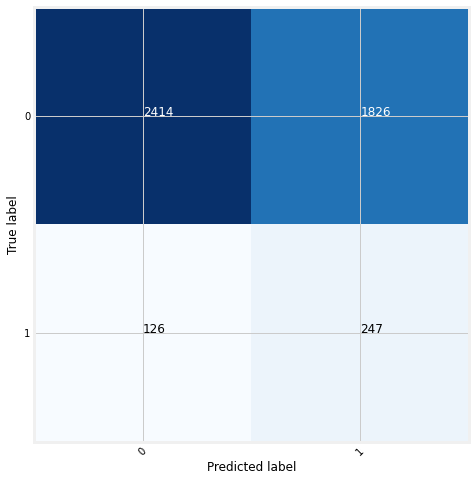

rf_over_under
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4240
           1       0.19      0.55      0.28       373

    accuracy                           0.78      4613
   macro avg       0.57      0.67      0.58      4613
weighted avg       0.89      0.78      0.82      4613



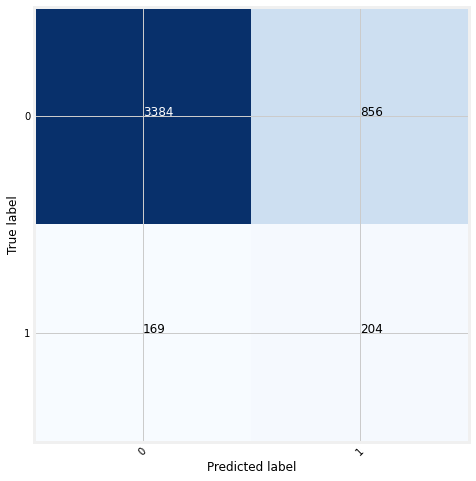

lgbm_over_under
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      4240
           1       0.16      0.64      0.26       373

    accuracy                           0.71      4613
   macro avg       0.56      0.68      0.54      4613
weighted avg       0.89      0.71      0.77      4613



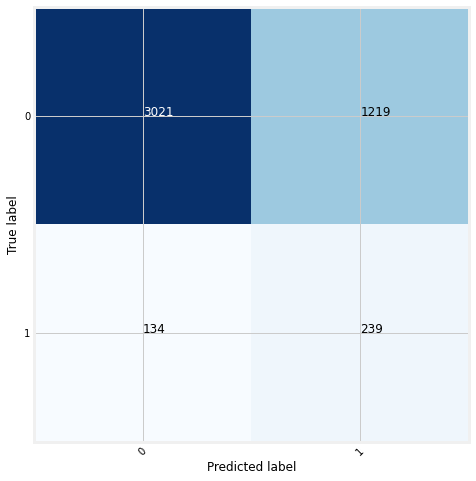

linearsvc_over_under
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      4240
           1       0.16      0.66      0.26       373

    accuracy                           0.69      4613
   macro avg       0.56      0.68      0.53      4613
weighted avg       0.89      0.69      0.76      4613



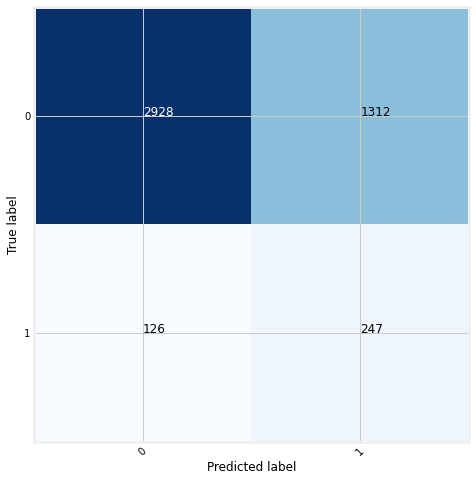

In [29]:
Result1=run_exps1(ech_Xtrain,ech_ytrain, X_val_final[selected_features],y_val)

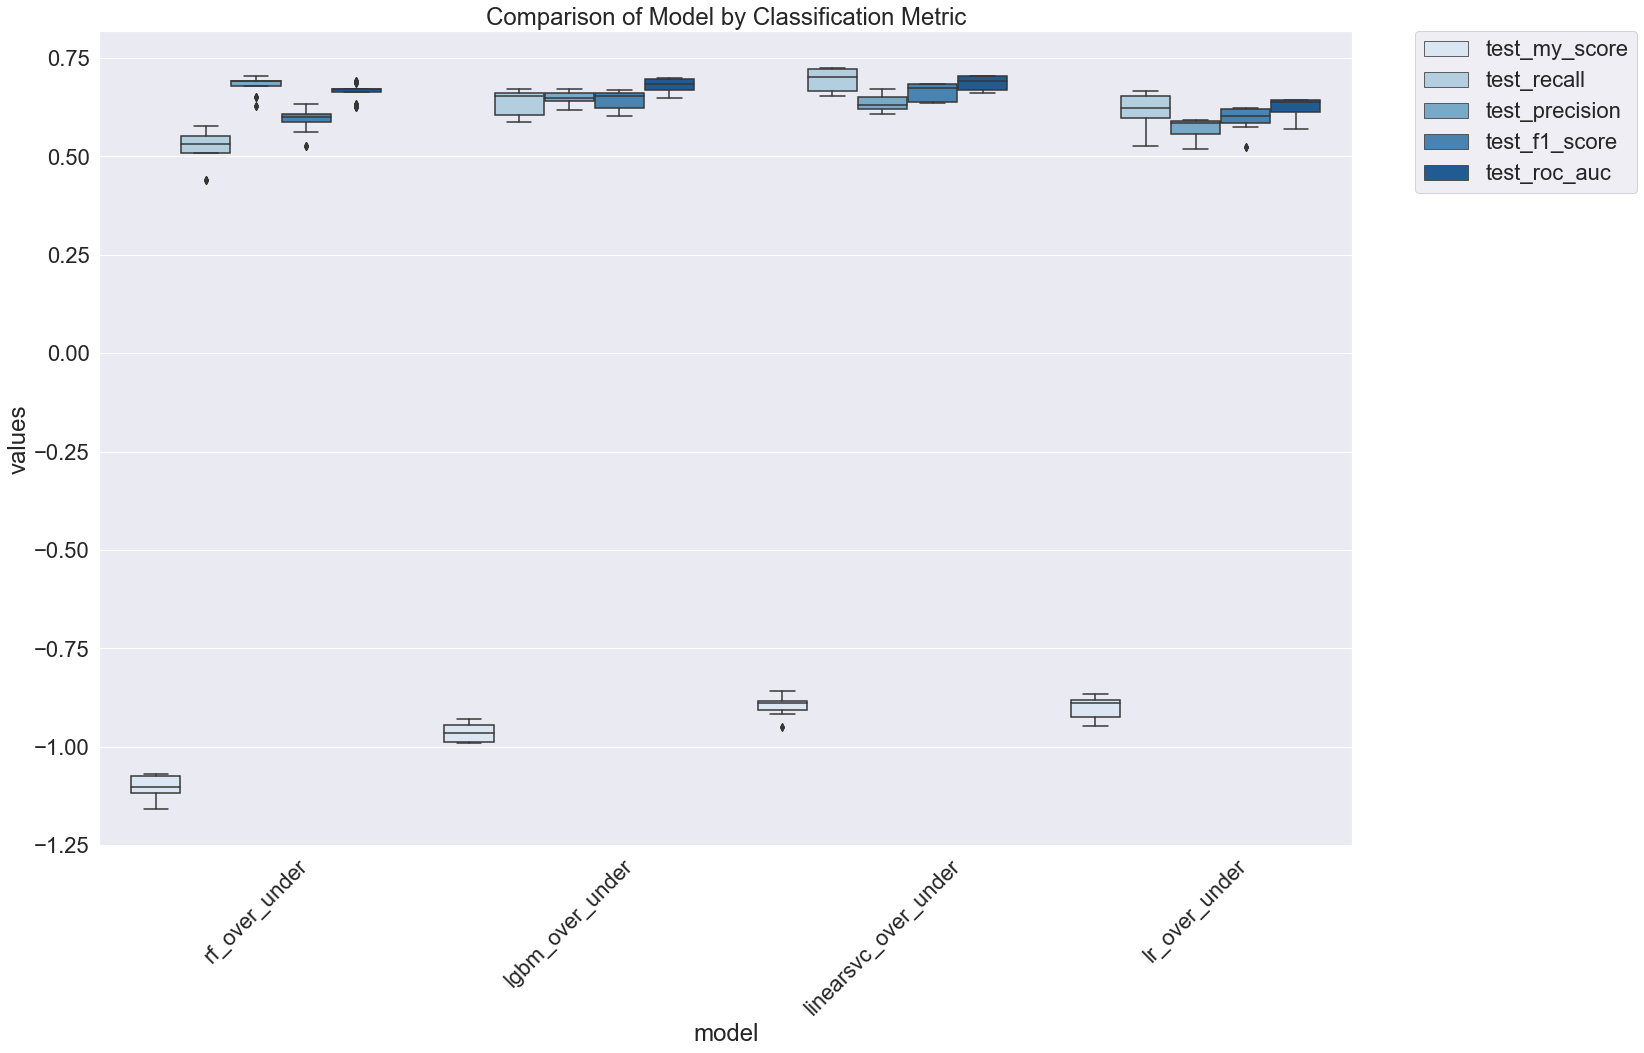

In [30]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [31]:
metrics = list(set(results_long_nofit.metrics.values))
RES_1=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_1

test_roc_auc test_precision test_recall test_my_score  \
                             mean           mean        mean          mean   
model                                                                        
lgbm_over_under          0.678689       0.645886    0.635920     -0.963583   
linearsvc_over_under     0.687204       0.634212    0.695427     -0.892300   
lr_over_under            0.625252       0.572439    0.620639     -0.900617   
rf_over_under            0.664365       0.680951    0.525280     -1.099067   

                     test_f1_score  
                              mean  
model                               
lgbm_over_under           0.640698  
linearsvc_over_under      0.663206  
lr_over_under             0.595319  
rf_over_under             0.592516

+ ### My approch with SMOTE oversampling

*Without class_weigth*

In [32]:
oversample = SMOTE()
ech_Xtrain,ech_ytrain = oversample.fit_resample(X_train_final[selected_features], y_train)

In [33]:
print('Before SMOTE oversample',X_train_final[selected_features].shape, y_train.shape)
print('After SMOTE oversample',ech_Xtrain.shape, ech_ytrain.shape)

Before SMOTE oversample (21525, 135) (21525,)
After SMOTE oversample (39576, 135) (39576,)


In [34]:
y_train.value_counts()

0    19788
1     1737
Name: TARGET, dtype: int64

In [35]:
ech_ytrain.value_counts()

0    19788
1    19788
Name: TARGET, dtype: int64

lr_oversampling
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      4240
           1       0.15      0.65      0.24       373

    accuracy                           0.67      4613
   macro avg       0.55      0.66      0.52      4613
weighted avg       0.89      0.67      0.75      4613



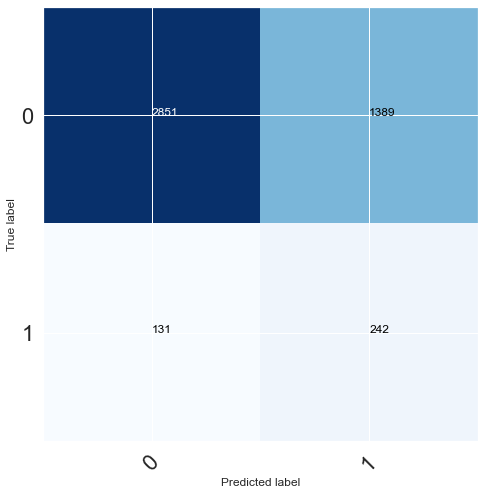

rf_oversampling
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4240
           1       0.20      0.03      0.05       373

    accuracy                           0.91      4613
   macro avg       0.56      0.51      0.50      4613
weighted avg       0.86      0.91      0.88      4613



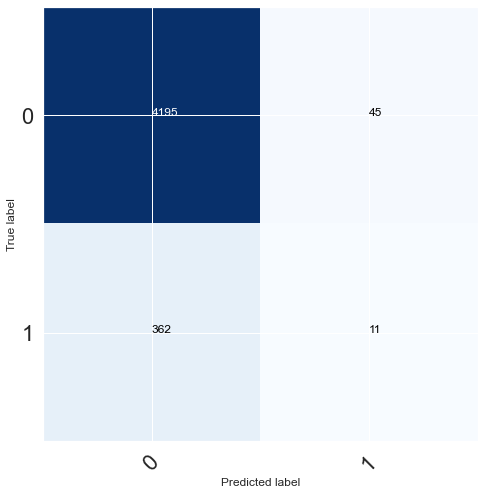

lgbm_oversampling
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4240
           1       0.44      0.05      0.09       373

    accuracy                           0.92      4613
   macro avg       0.68      0.52      0.52      4613
weighted avg       0.88      0.92      0.89      4613



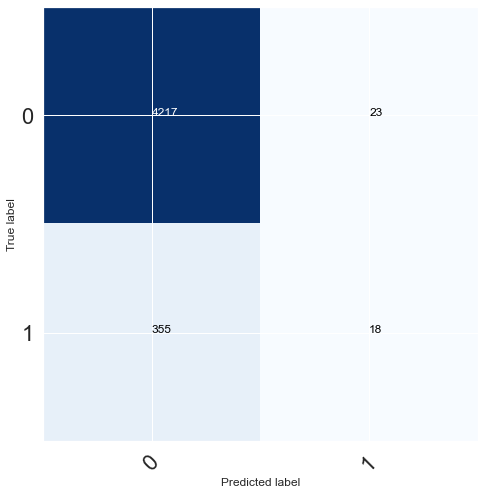

linearsvc_oversampling
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      4240
           1       0.16      0.62      0.25       373

    accuracy                           0.69      4613
   macro avg       0.56      0.66      0.53      4613
weighted avg       0.89      0.69      0.76      4613



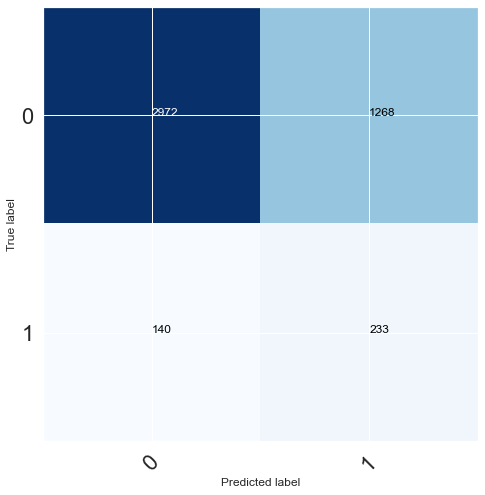

In [39]:
Result1=run_exps1(ech_Xtrain,ech_ytrain, X_val_final[selected_features],y_val)

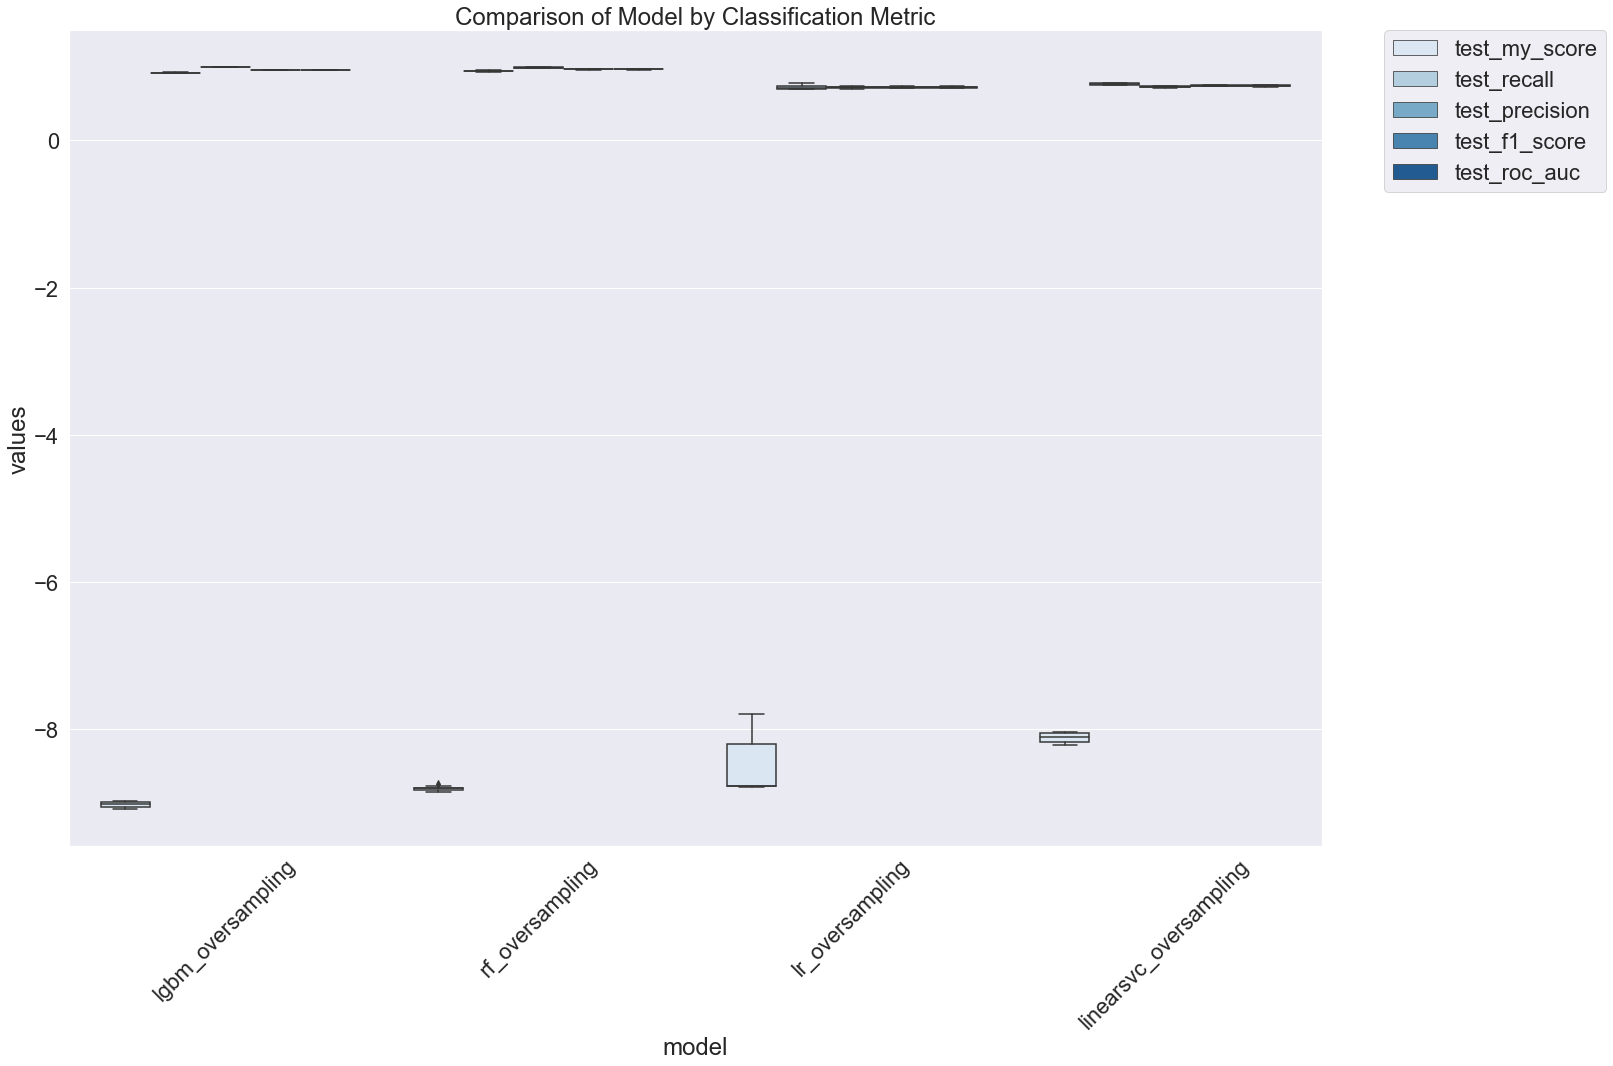

In [40]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [41]:
metrics = list(set(results_long_nofit.metrics.values))
RES_2=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_2

test_roc_auc test_precision test_recall test_my_score  \
                               mean           mean        mean          mean   
model                                                                          
lgbm_oversampling          0.952993       0.990663    0.914606     -9.023283   
linearsvc_oversampling     0.738586       0.726787    0.764545     -8.114000   
lr_oversampling            0.719167       0.719139    0.720404     -8.463183   
rf_oversampling            0.964361       0.986856    0.941256     -8.807183   

                       test_f1_score  
                                mean  
model                                 
lgbm_oversampling           0.951109  
linearsvc_oversampling      0.745176  
lr_oversampling             0.719259  
rf_oversampling             0.963513

+ ### My approch with Borderline SMOTE

*la méthode Borderline-SMOTE crée uniquement des exemples synthétiques le long de la frontière de décision entre les deux classes.*

In [42]:
from imblearn.over_sampling import BorderlineSMOTE

In [43]:
oversample = BorderlineSMOTE()
ech_Xtrain,ech_ytrain = oversample.fit_resample(X_train_final[selected_features], y_train)

In [44]:
print('Before SMOTE borderline',X_train_final[selected_features].shape, y_train.shape)
print('After SMOTE borderline',ech_Xtrain.shape, ech_ytrain.shape)

Before SMOTE borderline (21525, 135) (21525,)
After SMOTE borderline (39576, 135) (39576,)


In [45]:
y_train.value_counts()

0    19788
1     1737
Name: TARGET, dtype: int64

In [46]:
ech_ytrain.value_counts()

0    19788
1    19788
Name: TARGET, dtype: int64

lr_borderline
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      4240
           1       0.16      0.57      0.25       373

    accuracy                           0.73      4613
   macro avg       0.56      0.66      0.54      4613
weighted avg       0.89      0.73      0.79      4613



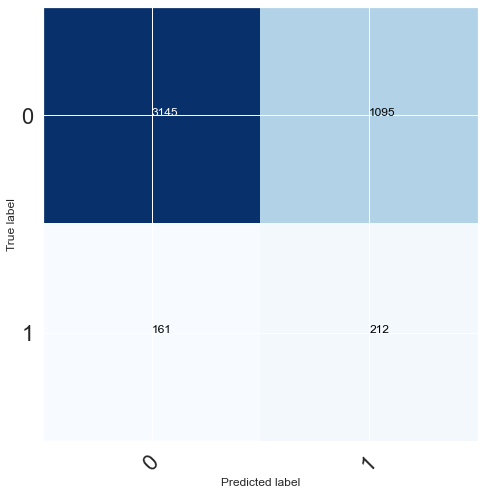

rf_borderline
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4240
           1       0.23      0.03      0.05       373

    accuracy                           0.91      4613
   macro avg       0.58      0.51      0.50      4613
weighted avg       0.87      0.91      0.88      4613



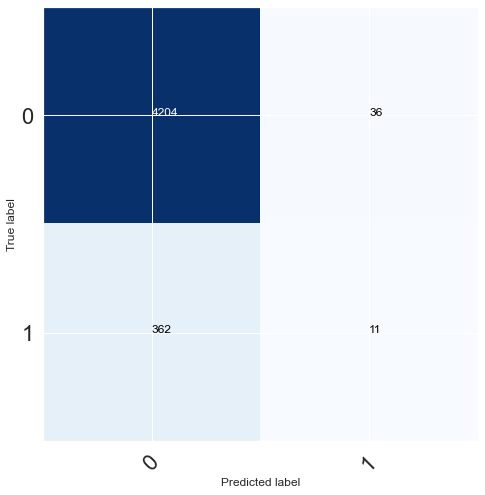

lgbm_borderline
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4240
           1       0.33      0.05      0.09       373

    accuracy                           0.91      4613
   macro avg       0.63      0.52      0.52      4613
weighted avg       0.87      0.91      0.89      4613



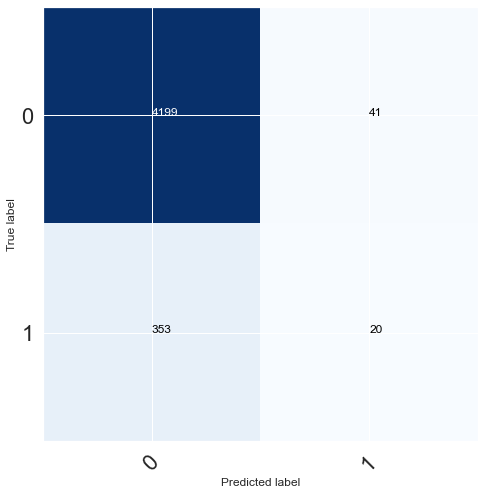

linearsvc_borderline
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      4240
           1       0.16      0.61      0.26       373

    accuracy                           0.72      4613
   macro avg       0.56      0.67      0.54      4613
weighted avg       0.89      0.72      0.78      4613



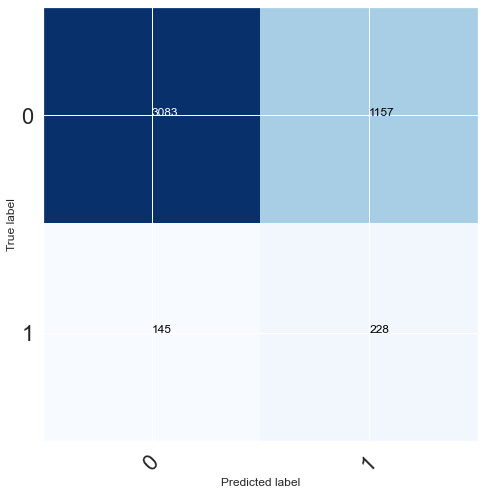

In [48]:
Result1=run_exps1(ech_Xtrain,ech_ytrain, X_val_final[selected_features],y_val)

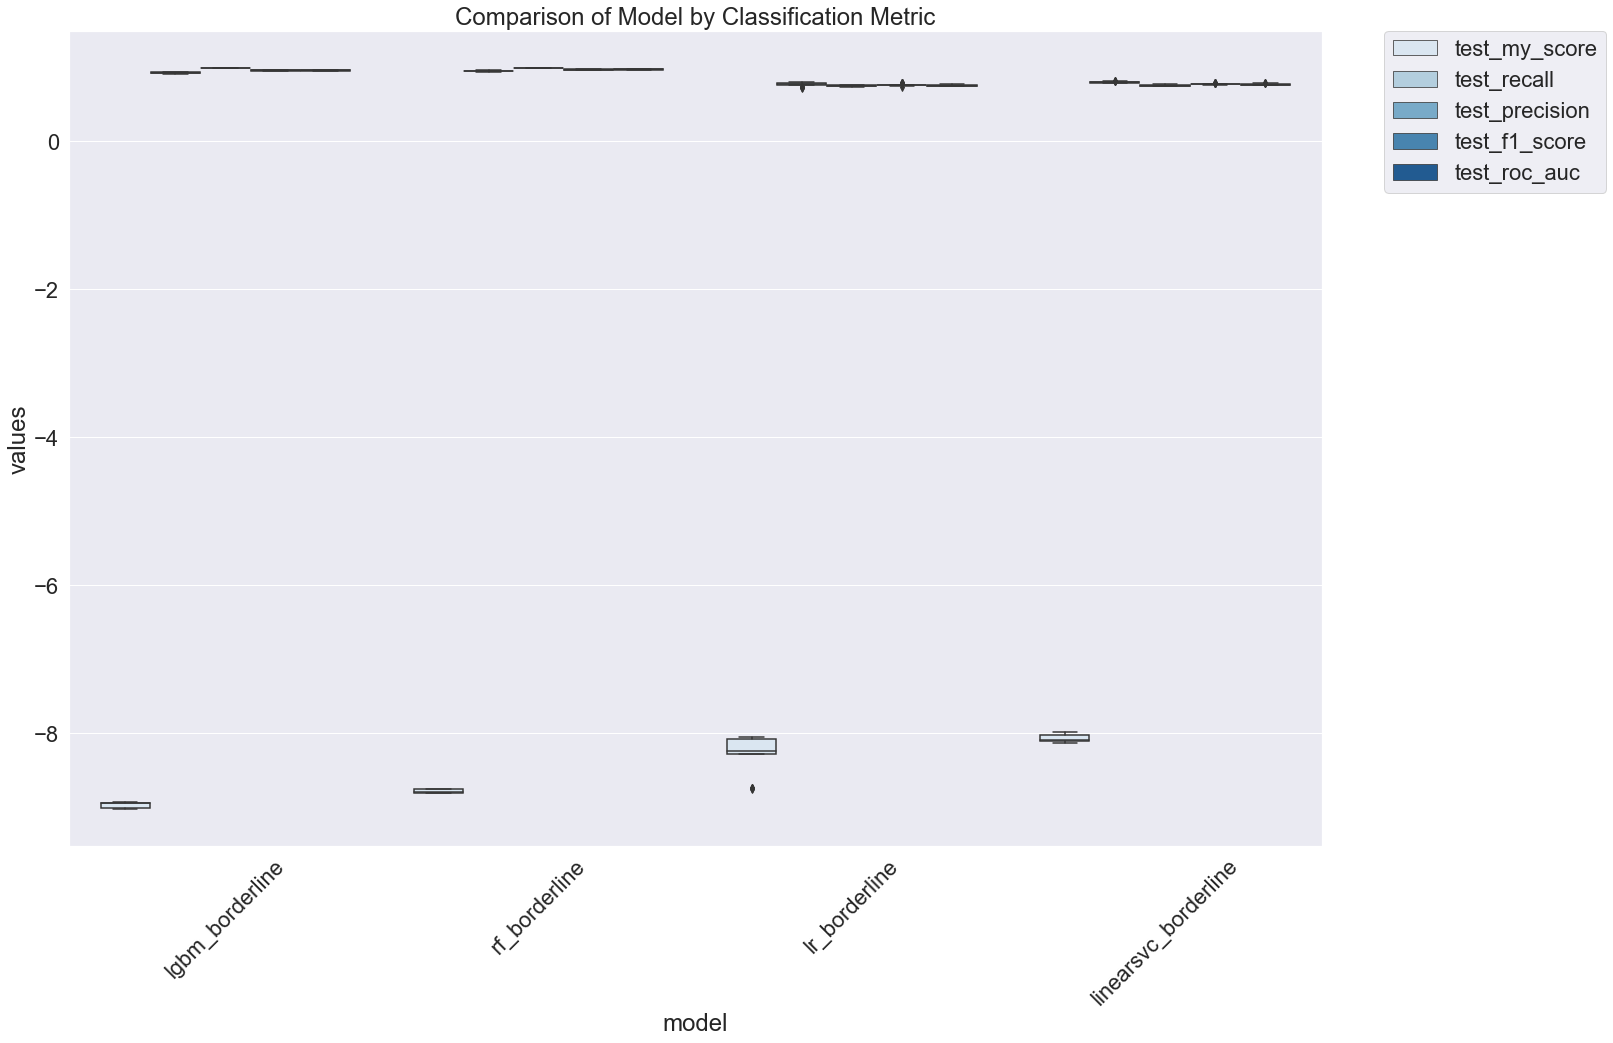

In [49]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [50]:
metrics = list(set(results_long_nofit.metrics.values))
RES_3=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_3

test_roc_auc test_precision test_recall test_my_score  \
                             mean           mean        mean          mean   
model                                                                        
lgbm_borderline          0.953759       0.987542    0.919110     -8.970150   
linearsvc_borderline     0.765570       0.750933    0.794703     -8.068867   
lr_borderline            0.753008       0.745154    0.769170     -8.252183   
rf_borderline            0.965963       0.987138    0.944225     -8.787550   

                     test_f1_score  
                              mean  
model                               
lgbm_borderline           0.952091  
linearsvc_borderline      0.772188  
lr_borderline             0.756764  
rf_borderline             0.965202

+ ### My Approch with SVM limite-SMOTE

*Un SVM est utilisé pour localiser la frontière de décision définie par les vecteurs de support et les exemples dans la classe minoritaire qui, proches des vecteurs de support, deviennent le centre de génération d'exemples synthétiques.*

In [51]:
from imblearn.over_sampling import SVMSMOTE

In [52]:
oversample = SVMSMOTE()
ech_Xtrain,ech_ytrain = oversample.fit_resample(X_train_final[selected_features], y_train)

In [54]:
print('Before SVMSMOTE',X_train_final[selected_features].shape, y_train.shape)
print('After SVMSMOTE ',ech_Xtrain.shape, ech_ytrain.shape)

Before SVMSMOTE (21525, 135) (21525,)
After SVMSMOTE  (39576, 135) (39576,)


In [55]:
ech_ytrain.value_counts()

0    19788
1    19788
Name: TARGET, dtype: int64

lr_svm
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      4240
           1       0.21      0.40      0.27       373

    accuracy                           0.83      4613
   macro avg       0.57      0.63      0.59      4613
weighted avg       0.88      0.83      0.85      4613



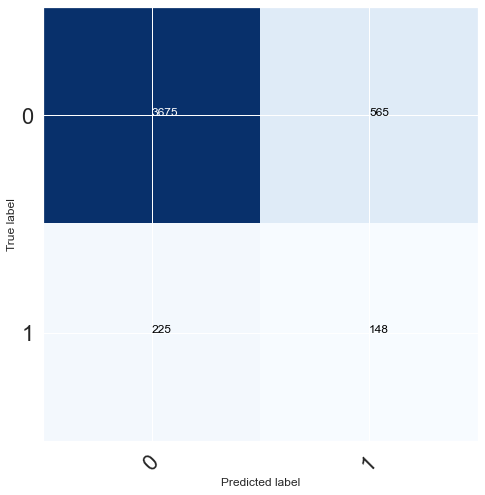

rf_svm
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4240
           1       0.30      0.02      0.03       373

    accuracy                           0.92      4613
   macro avg       0.61      0.51      0.49      4613
weighted avg       0.87      0.92      0.88      4613



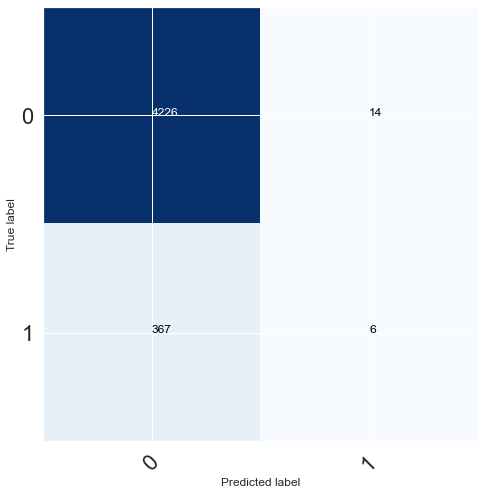

lgbm_svm
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4240
           1       0.24      0.04      0.06       373

    accuracy                           0.91      4613
   macro avg       0.58      0.51      0.51      4613
weighted avg       0.87      0.91      0.88      4613



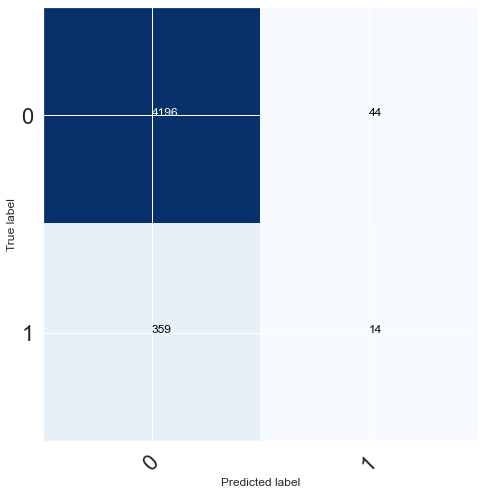

linearsvc_svm
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      4240
           1       0.22      0.37      0.28       373

    accuracy                           0.85      4613
   macro avg       0.58      0.63      0.60      4613
weighted avg       0.88      0.85      0.86      4613



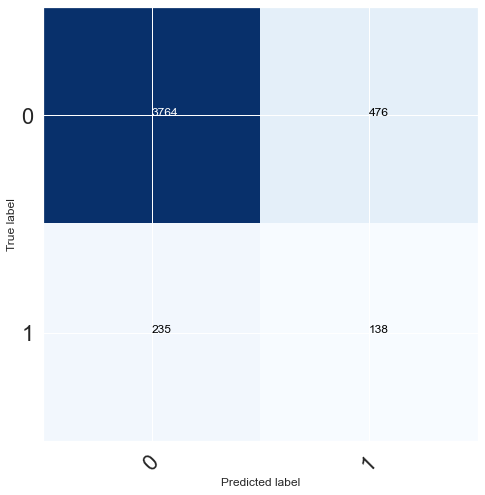

In [56]:
Result1=run_exps1(ech_Xtrain,ech_ytrain, X_val_final[selected_features],y_val)

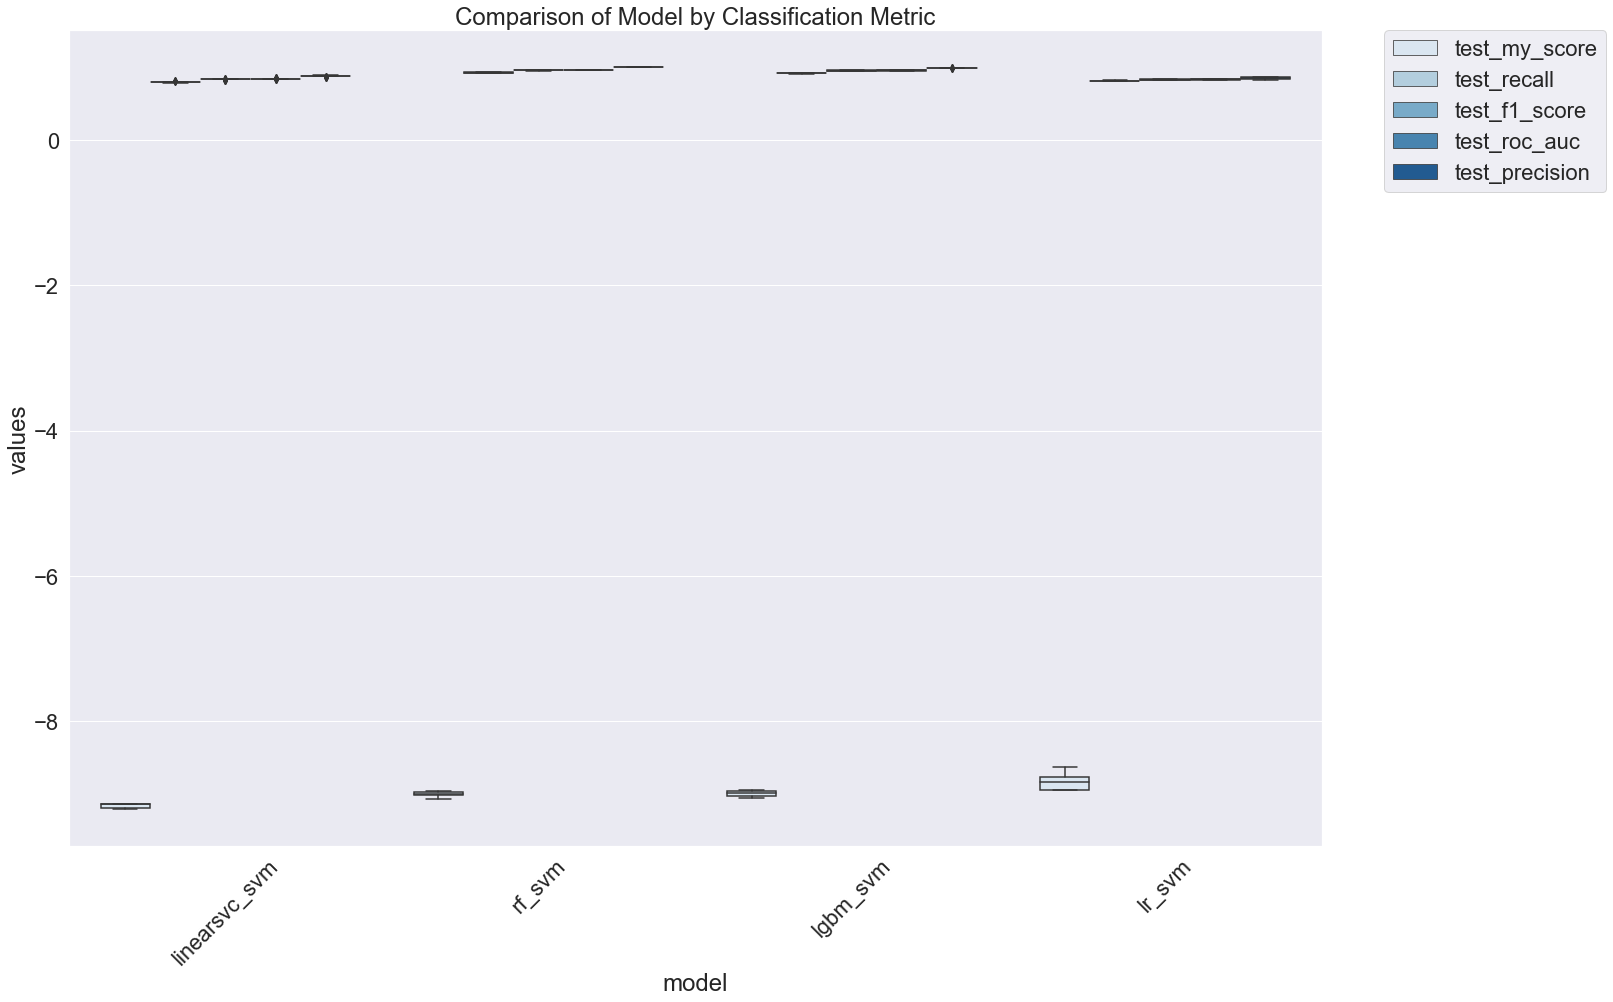

In [57]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [58]:
metrics = list(set(results_long_nofit.metrics.values))
RES_4=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_4

test_roc_auc test_precision test_recall test_my_score  \
                      mean           mean        mean          mean   
model                                                                 
lgbm_svm          0.953736       0.989401    0.917305     -8.995417   
linearsvc_svm     0.840876       0.877325    0.792580     -9.163283   
lr_svm            0.831928       0.849532    0.806983     -8.833183   
rf_svm            0.959307       0.995775    0.922529     -9.000233   

              test_f1_score  
                       mean  
model                        
lgbm_svm           0.951980  
linearsvc_svm      0.832799  
lr_svm             0.827659  
rf_svm             0.957747

+ ### My Approch with ADASYN

<font color='blue'>ADASYN est basé sur l'idée de générer de manière adaptative des échantillons de données minoritaires en fonction de leurs distributions: plus de données synthétiques sont générées pour les échantillons de classe minoritaire qui sont plus difficiles à apprendre par rapport aux échantillons minoritaires qui sont plus faciles à apprendre.L'idée clé de l'algorithme ADASYN est d'utiliser une distribution de densité comme critère pour décider automatiquement du nombre d'échantillons synthétiques qui doivent être générés pour chaque exemple de données minoritaires.</font>

In [59]:
from imblearn.over_sampling import ADASYN

In [60]:
oversample = ADASYN()
ech_Xtrain,ech_ytrain = oversample.fit_resample(X_train_final[selected_features], y_train)

In [61]:
print('Before ADASYN',X_train_final[selected_features].shape, y_train.shape)
print('After ADASYN ',ech_Xtrain.shape, ech_ytrain.shape)

Before ADASYN (21525, 135) (21525,)
After ADASYN  (39485, 135) (39485,)


In [64]:
y_train.value_counts()

0    19788
1     1737
Name: TARGET, dtype: int64

In [62]:
ech_ytrain.value_counts()

0    19788
1    19697
Name: TARGET, dtype: int64

lr_adasyn
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      4240
           1       0.16      0.59      0.26       373

    accuracy                           0.72      4613
   macro avg       0.56      0.66      0.54      4613
weighted avg       0.89      0.72      0.78      4613



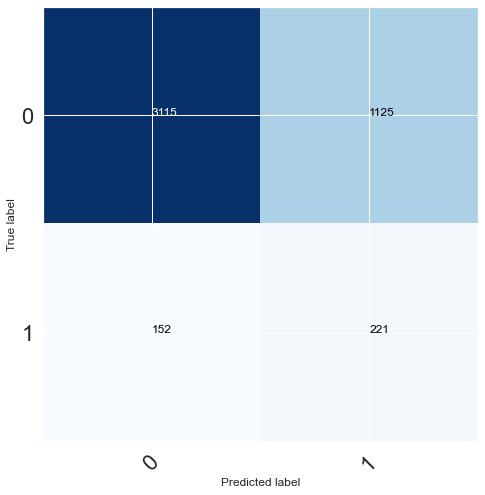

rf_adasyn
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4240
           1       0.25      0.04      0.07       373

    accuracy                           0.91      4613
   macro avg       0.59      0.51      0.51      4613
weighted avg       0.87      0.91      0.88      4613



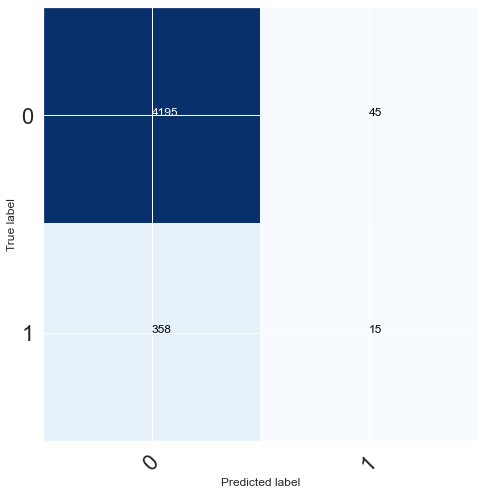

lgbm_adasyn
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4240
           1       0.39      0.04      0.08       373

    accuracy                           0.92      4613
   macro avg       0.66      0.52      0.52      4613
weighted avg       0.88      0.92      0.89      4613



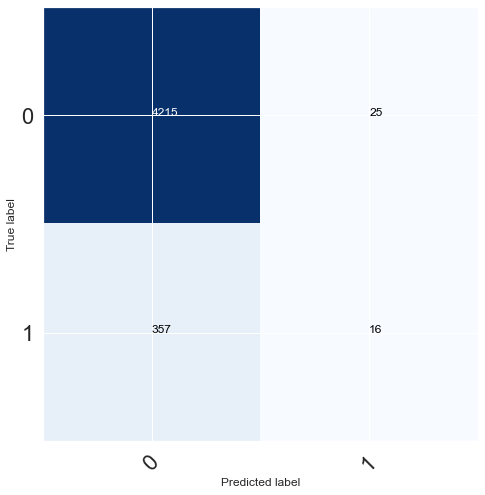

linearsvc_adasyn
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      4240
           1       0.15      0.64      0.25       373

    accuracy                           0.69      4613
   macro avg       0.55      0.66      0.53      4613
weighted avg       0.89      0.69      0.76      4613



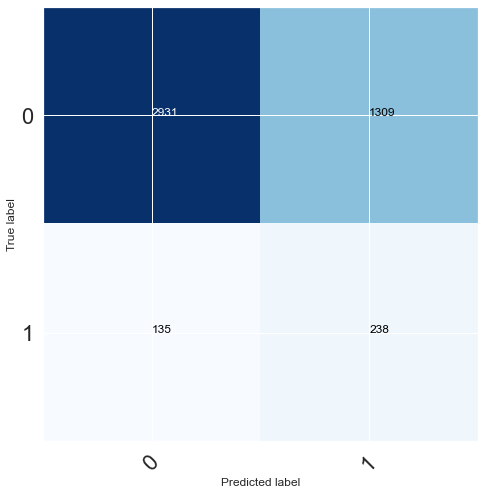

In [65]:
Result1=run_exps1(ech_Xtrain,ech_ytrain, X_val_final[selected_features],y_val)

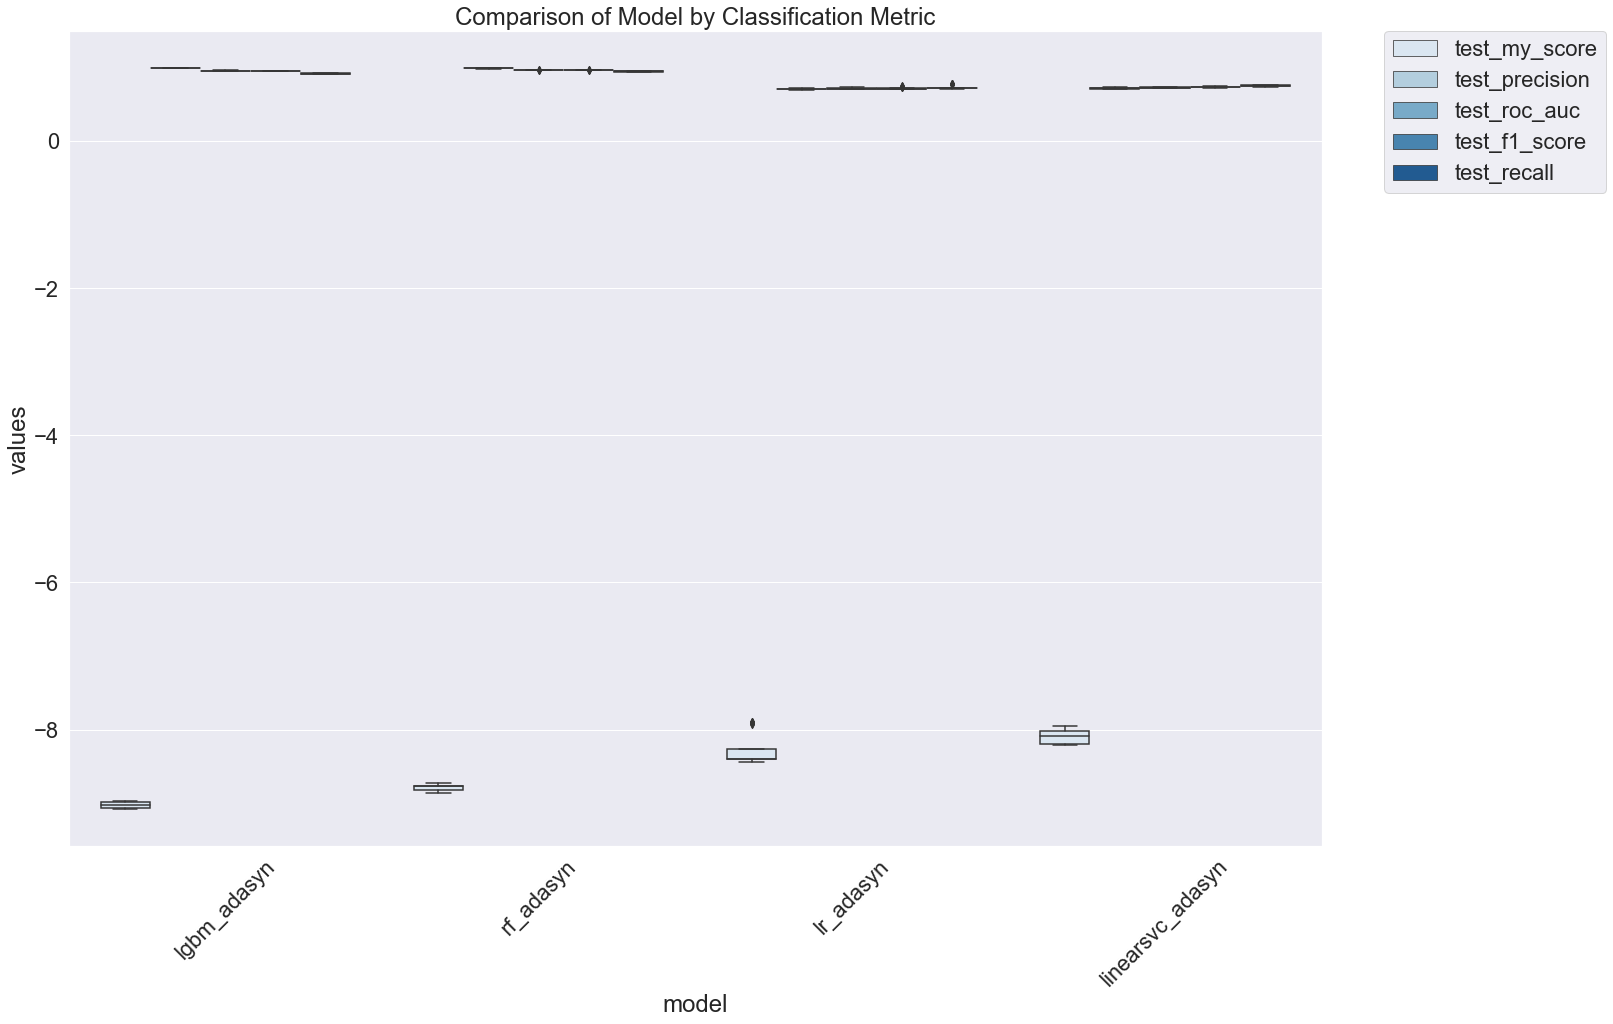

In [66]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [67]:
metrics = list(set(results_long_nofit.metrics.values))
RES_5=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_5

test_roc_auc test_precision test_recall test_my_score  \
                         mean           mean        mean          mean   
model                                                                    
lgbm_adasyn          0.954303       0.992529    0.915468     -9.026567   
linearsvc_adasyn     0.725957       0.713552    0.752817     -8.093050   
lr_adasyn            0.714763       0.707833    0.728975     -8.271067   
rf_adasyn            0.965959       0.987074    0.944240     -8.785867   

                 test_f1_score  
                          mean  
model                           
lgbm_adasyn           0.952434  
linearsvc_adasyn      0.732631  
lr_adasyn             0.718123  
rf_adasyn             0.965169

+ ### My approch with BalancedBaggingClassifier

In [68]:
from imblearn.ensemble import BalancedBaggingClassifier

In [69]:
def run_exps2(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models=[('RandomForest_bag',BalancedBaggingClassifier(
        base_estimator=RandomForestClassifier(class_weight='balanced',random_state=42),
        n_estimators=100, random_state=42, n_jobs=-1)),
            
            ('Lgbm_bag',BalancedBaggingClassifier(
        base_estimator=lgb.LGBMClassifier(class_weight='balanced',random_state=42),
        n_estimators=100, random_state=42, n_jobs=-1)),
            ('LogisticR_bag',BalancedBaggingClassifier(
        base_estimator=SGDClassifier(penalty='l1',class_weight = 'balanced', loss='log', random_state=42),
        n_estimators=100, random_state=42, n_jobs=-1)),
            
            ('Linearscv_bag',BalancedBaggingClassifier(
        base_estimator=LinearSVC(class_weight='balanced',random_state=42),
        n_estimators=100, random_state=42, n_jobs=-1))
           ]

    results = []
    names = []
    scoring = {'roc_auc': make_scorer(roc_auc_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'my_score': make_scorer(my_score, greater_is_better=False)
               }

    scoring1 = {  # 'my_score': make_scorer(my_score, greater_is_better=True),
        'roc_auc': make_scorer(roc_auc_score)
    }
    target_names = ['0', '1']
    for name, model in models:
        cv = model_selection.StratifiedKFold(
            n_splits=7, shuffle=True, random_state=42)
        cv_results = model_selection.cross_validate(
            model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        print(name)
        print(classification_report(y_val, y_pred, target_names=target_names))
        pretty_print_conf_matrix(y_val, y_pred, ['0', '1'])
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

RandomForest_bag
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4240
           1       0.20      0.50      0.28       373

    accuracy                           0.79      4613
   macro avg       0.57      0.66      0.58      4613
weighted avg       0.89      0.79      0.83      4613



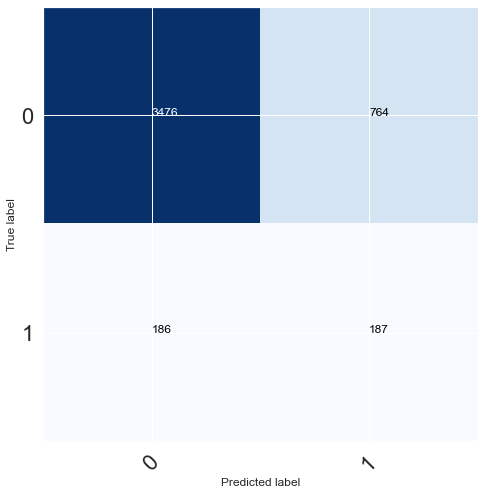

Lgbm_bag
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      4240
           1       0.20      0.60      0.30       373

    accuracy                           0.77      4613
   macro avg       0.58      0.69      0.58      4613
weighted avg       0.90      0.77      0.82      4613



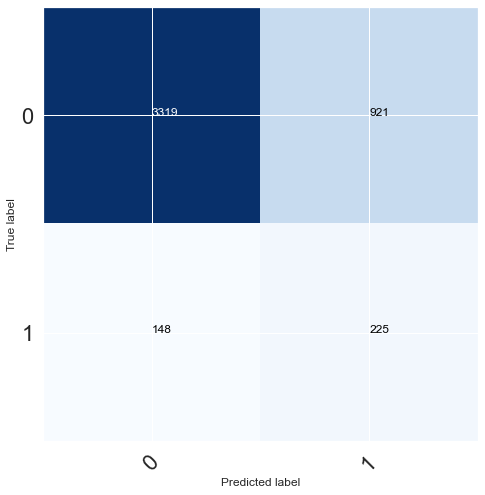

LogisticR_bag
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      4240
           1       0.16      0.67      0.26       373

    accuracy                           0.69      4613
   macro avg       0.56      0.68      0.53      4613
weighted avg       0.90      0.69      0.76      4613



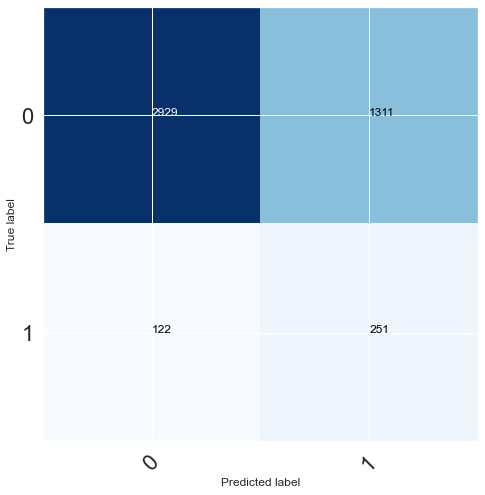

Linearscv_bag
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      4240
           1       0.17      0.68      0.27       373

    accuracy                           0.70      4613
   macro avg       0.56      0.69      0.54      4613
weighted avg       0.90      0.70      0.77      4613



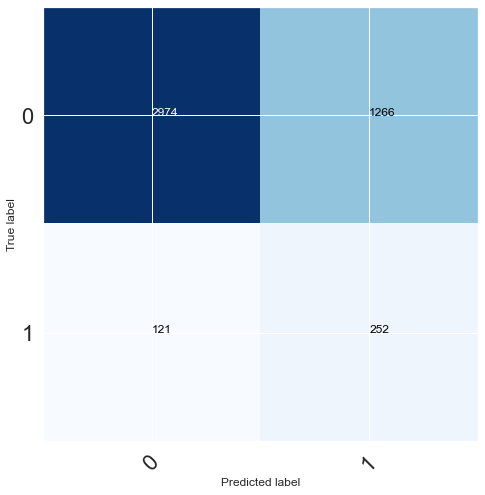

In [70]:
Result1=run_exps2(X_train_final[selected_features],y_train, X_val_final[selected_features],y_val)

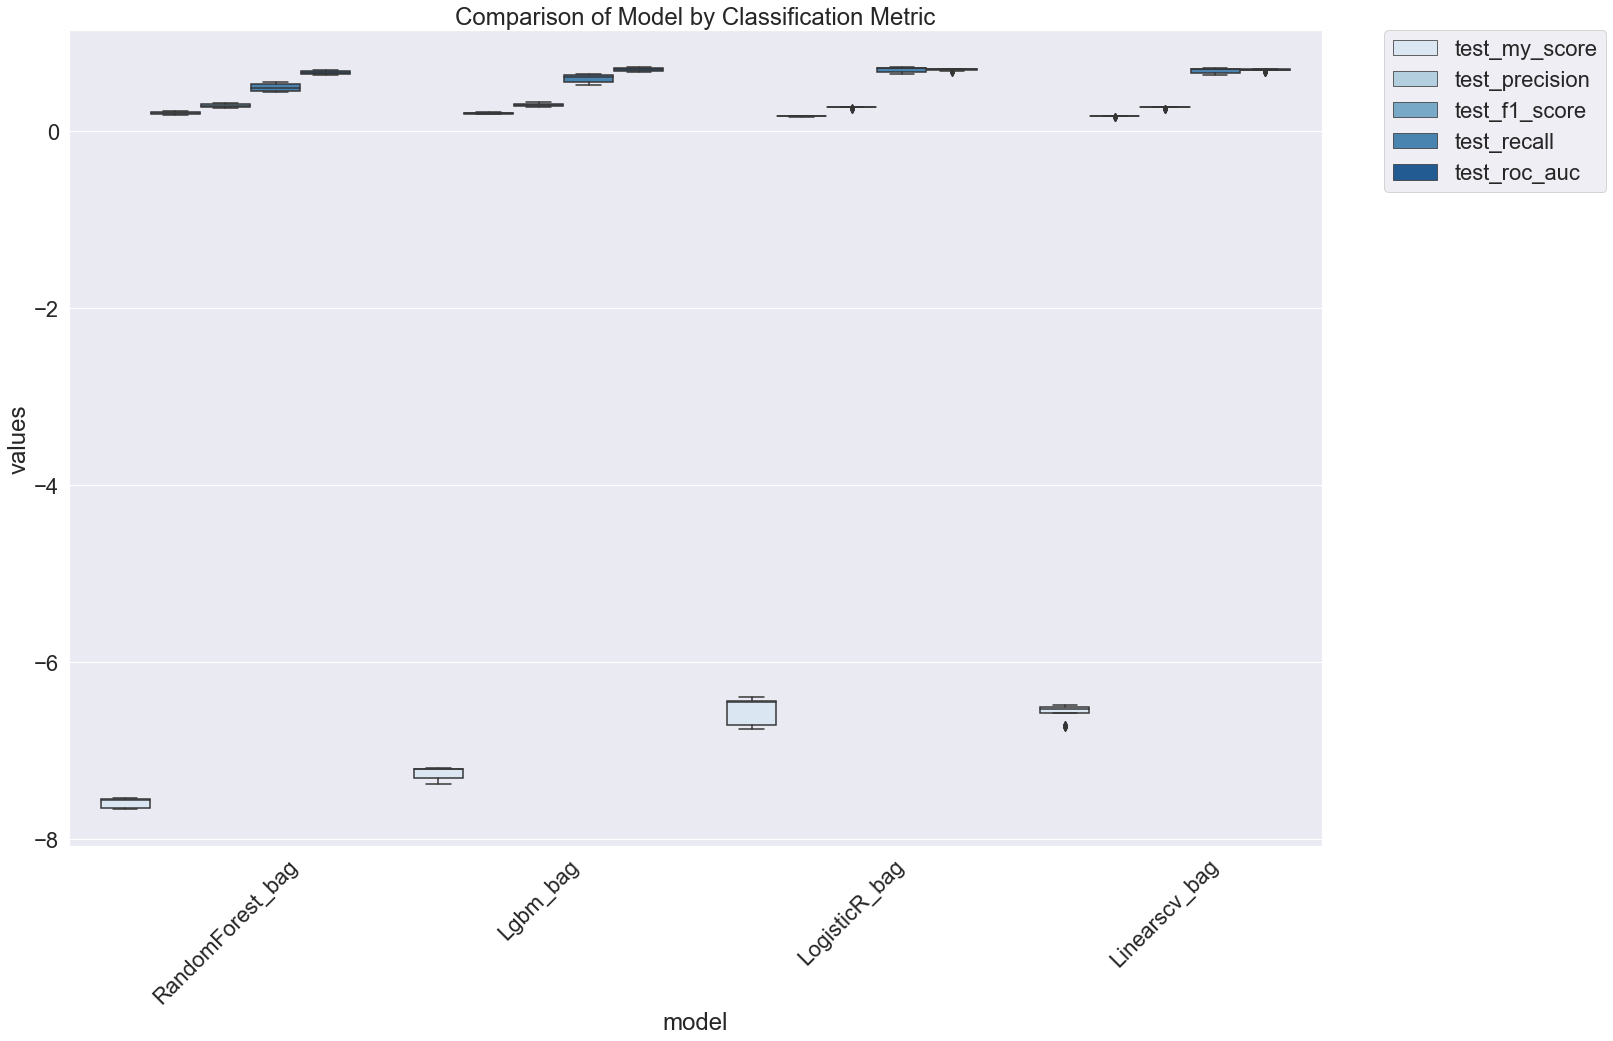

In [71]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [72]:
metrics = list(set(results_long_nofit.metrics.values))
RES_6=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_6

test_roc_auc test_precision test_recall test_my_score  \
                         mean           mean        mean          mean   
model                                                                    
Lgbm_bag             0.690146       0.197940    0.589952     -7.253150   
Linearscv_bag        0.690364       0.166492    0.679547     -6.567483   
LogisticR_bag        0.691047       0.165684    0.685583     -6.530733   
RandomForest_bag     0.661049       0.201771    0.493259     -7.585233   

                 test_f1_score  
                          mean  
model                           
Lgbm_bag              0.296359  
Linearscv_bag         0.267408  
LogisticR_bag         0.266760  
RandomForest_bag      0.286334

+ ### My Approch without Modified

lr
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      4240
           1       0.15      0.65      0.25       373

    accuracy                           0.68      4613
   macro avg       0.55      0.66      0.52      4613
weighted avg       0.89      0.68      0.75      4613



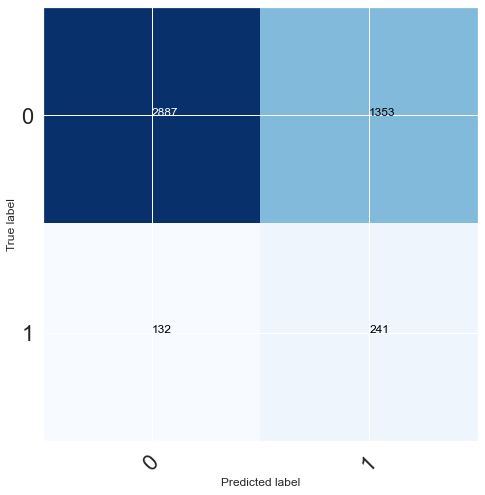

rf
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4240
           1       0.00      0.00      0.00       373

    accuracy                           0.92      4613
   macro avg       0.46      0.50      0.48      4613
weighted avg       0.84      0.92      0.88      4613



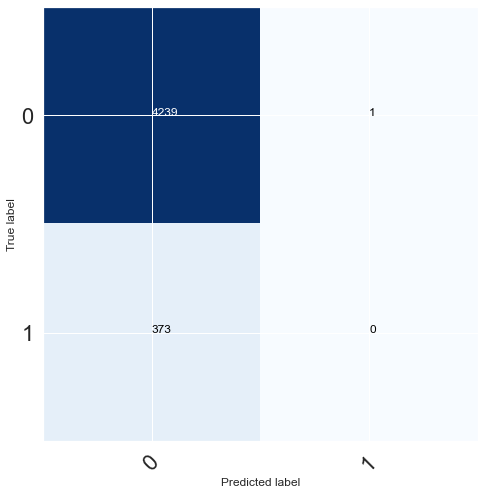

lgbm
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      4240
           1       0.20      0.46      0.28       373

    accuracy                           0.81      4613
   macro avg       0.57      0.65      0.58      4613
weighted avg       0.89      0.81      0.84      4613



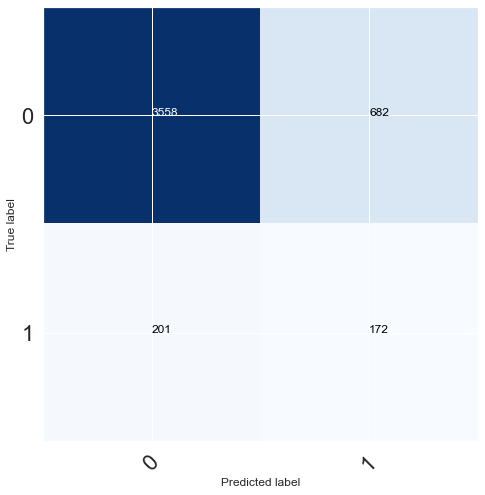

linearsvc
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      4240
           1       0.18      0.58      0.27       373

    accuracy                           0.74      4613
   macro avg       0.56      0.67      0.56      4613
weighted avg       0.89      0.74      0.80      4613



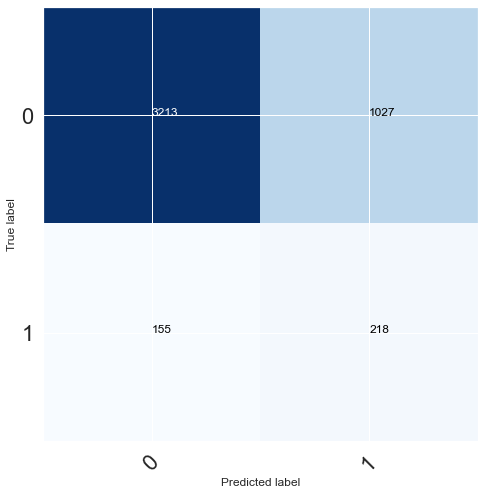

In [74]:
Result1=run_exps1(X_train_final[selected_features],y_train, X_val_final[selected_features],y_val)

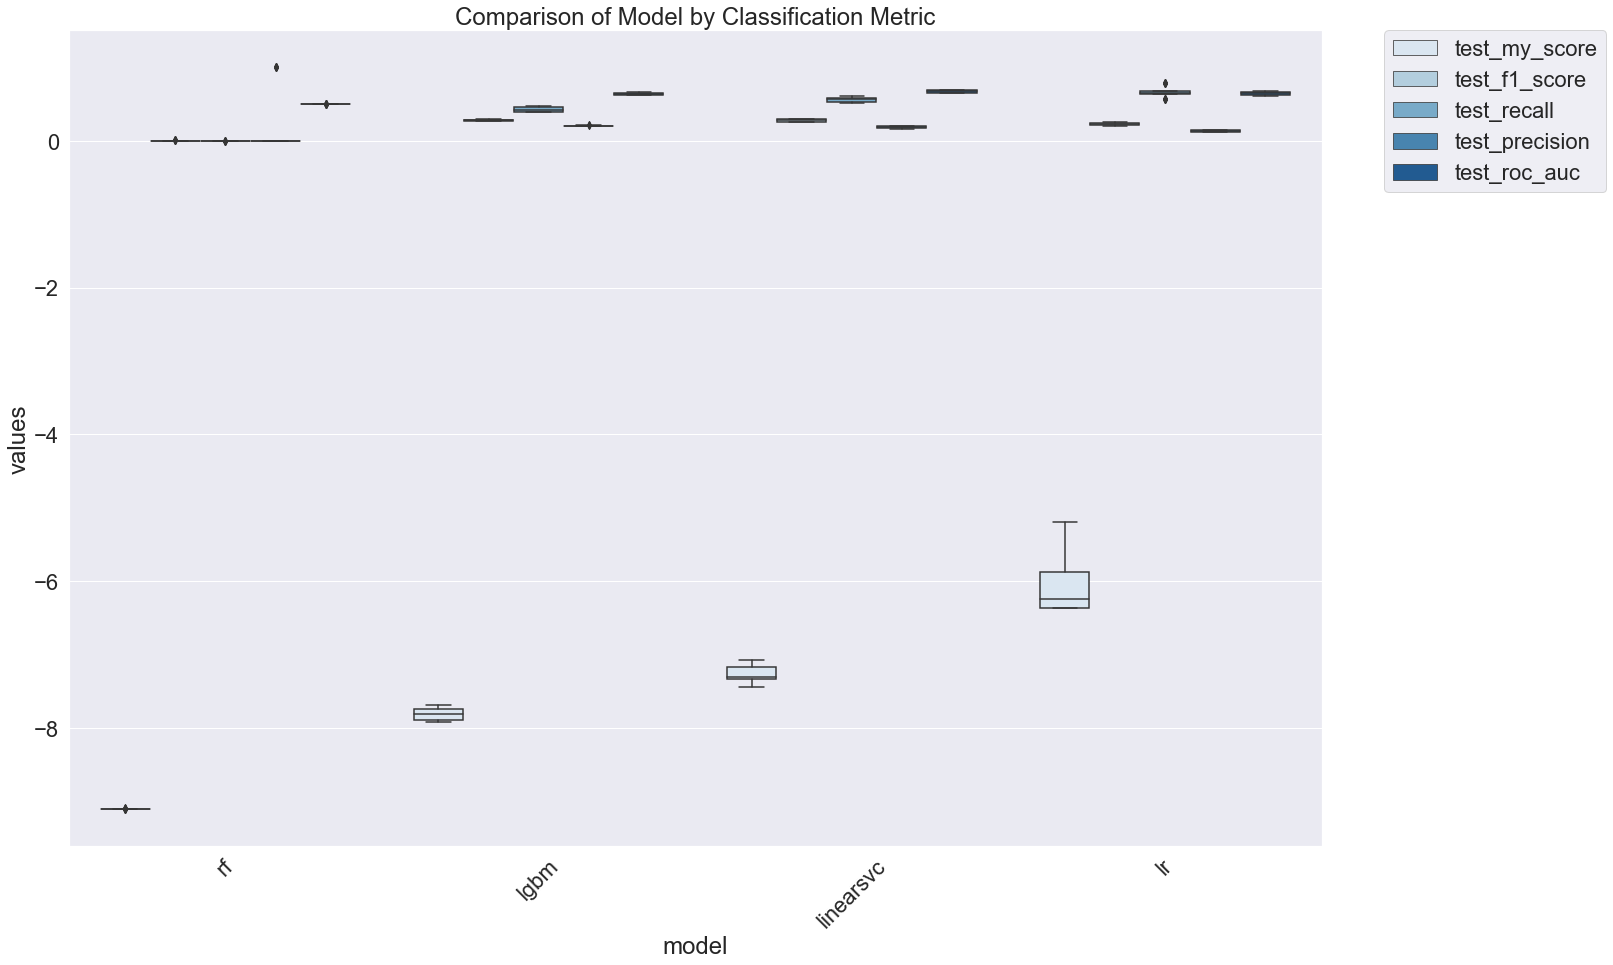

In [75]:
bootstraps = []
for model in list(set(Result1.model.values)):
    model_df = Result1.loc[Result1.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

bootstrap_df1 = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df1, id_vars=[
                       'model'], var_name='metrics', value_name='values')
time_metrics = ['fit_time', 'score_time']  # fit time metrics
# PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)]  # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
# TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)]  # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

plt.figure(figsize=(20, 15))
sns.set(font_scale=2)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit,palette="Blues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [76]:
metrics = list(set(results_long_nofit.metrics.values))
RES_7=bootstrap_df1.groupby(['model'])[metrics].agg([np.mean])
RES_7

test_roc_auc test_precision test_recall test_my_score test_f1_score
                  mean           mean        mean          mean          mean
model                                                                        
lgbm          0.642280       0.206309    0.429553     -7.809750      0.278531
linearsvc     0.674962       0.190346    0.559940     -7.269217      0.283905
lr            0.647028       0.137088    0.664525     -6.070500      0.226780
rf            0.500312       0.166667    0.000672     -9.100150      0.001339

#### Comparaison temps d'apprentissage et temps de predictions

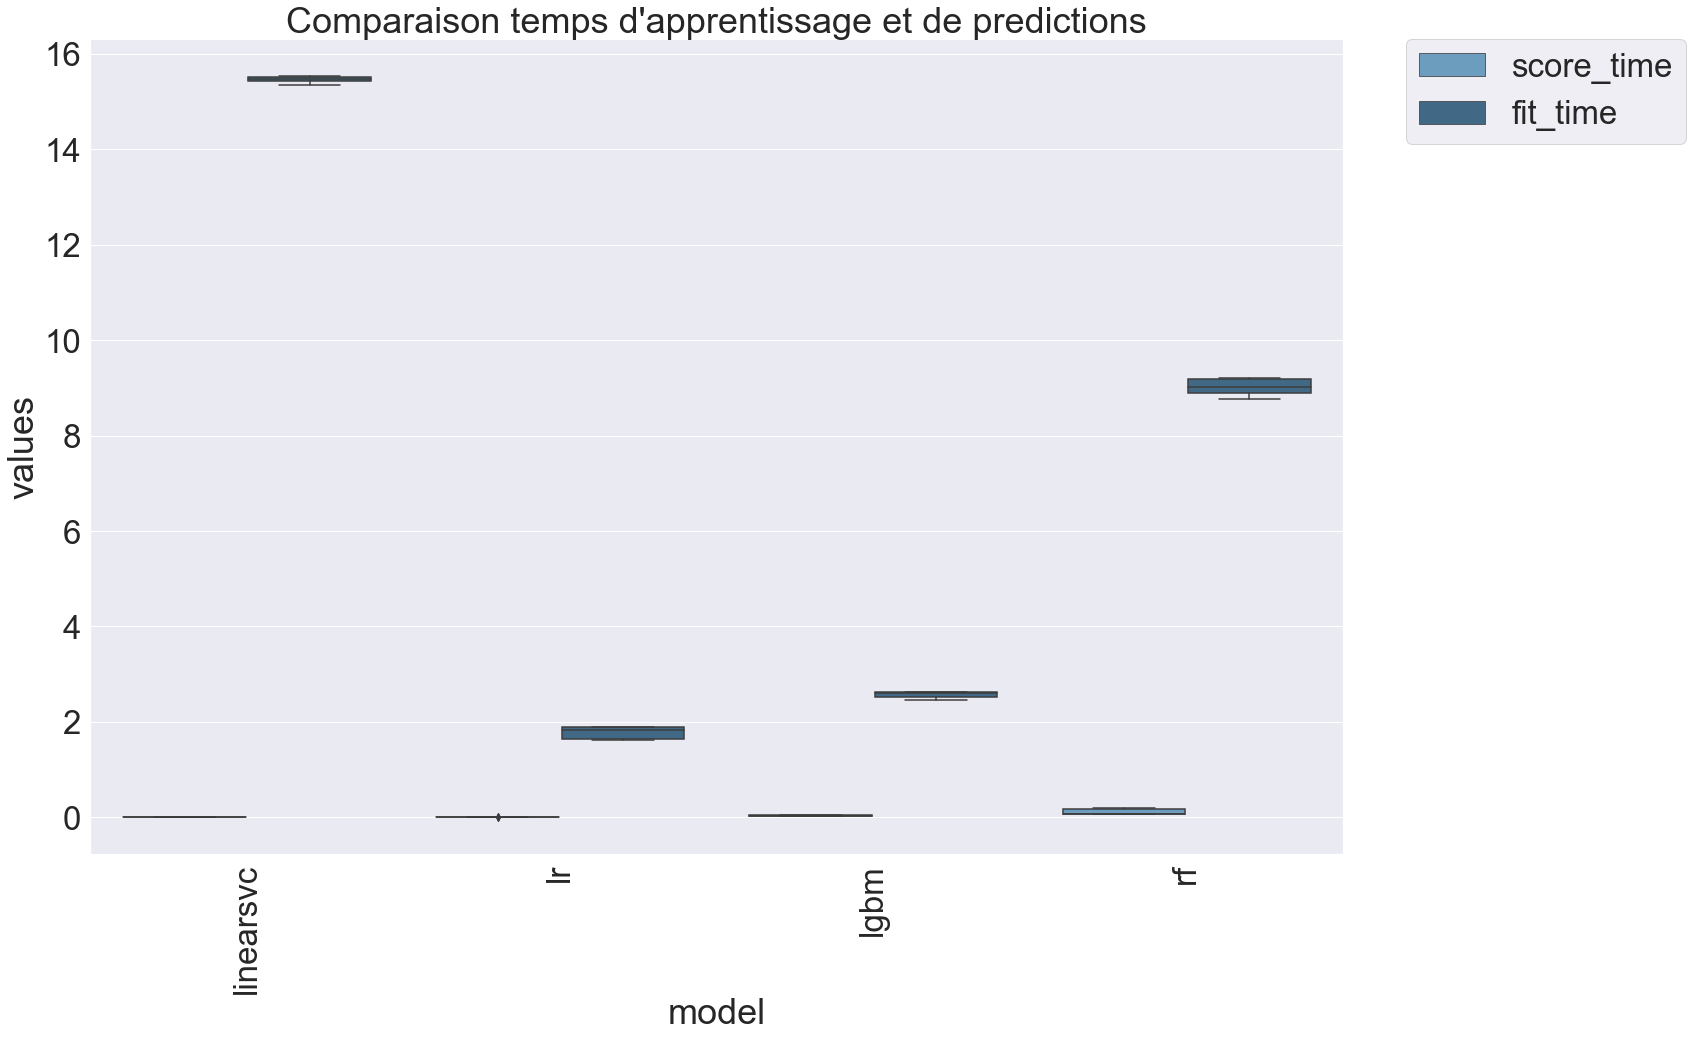

In [82]:
plt.figure(figsize=(20, 15))
sns.set(font_scale=3)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Blues_d")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Comparaison temps d'apprentissage et de predictions")
plt.setp(g.get_xticklabels(), rotation=90)
plt.show()

+ ### Comparison of the different approaches

In [77]:
res_compare=pd.concat([RES_1,RES_2,RES_3,RES_4,RES_5,RES_6,RES_7],0).reset_index()
res_compare.columns=['Model','test_roc_auc','test_recall','test_precision','test_my_score','test_f1_score']
res_compare

Model  test_roc_auc  test_recall  test_precision  \
0          lgbm_over_under      0.678689     0.645886        0.635920   
1     linearsvc_over_under      0.687204     0.634212        0.695427   
2            lr_over_under      0.625252     0.572439        0.620639   
3            rf_over_under      0.664365     0.680951        0.525280   
4        lgbm_oversampling      0.952993     0.990663        0.914606   
5   linearsvc_oversampling      0.738586     0.726787        0.764545   
6          lr_oversampling      0.719167     0.719139        0.720404   
7          rf_oversampling      0.964361     0.986856        0.941256   
8          lgbm_borderline      0.953759     0.987542        0.919110   
9     linearsvc_borderline      0.765570     0.750933        0.794703   
10           lr_borderline      0.753008     0.745154        0.769170   
11           rf_borderline      0.965963     0.987138        0.944225   
12                lgbm_svm      0.953736     0.989401        0.917305   
13           linearsvc_svm      0.840876     0.877325        0.792580   
14                  lr_svm      0.831928     0.849532        0.806983   
15                  rf_svm      0.959307     0.995775        0.922529   
16             lgbm_adasyn      0.954303     0.992529        0.915468   
17        linearsvc_adasyn      0.725957     0.713552        0.752817   
18               lr_adasyn      0.714763     0.707833        0.728975   
19               rf_adasyn      0.965959     0.987074        0.944240   
20                Lgbm_bag      0.690146     0.197940        0.589952   
21           Linearscv_bag      0.690364     0.166492        0.679547   
22           LogisticR_bag      0.691047     0.165684        0.685583   
23        RandomForest_bag      0.661049     0.201771        0.493259   
24                    lgbm      0.642280     0.206309        0.429553   
25               linearsvc      0.674962     0.190346        0.559940   
26                      lr      0.647028     0.137088        0.664525   
27                      rf      0.500312     0.166667        0.000672   

    test_my_score  test_f1_score  
0       -0.963583       0.640698  
1       -0.892300       0.663206  
2       -0.900617       0.595319  
3       -1.099067       0.592516  
4       -9.023283       0.951109  
5       -8.114000       0.745176  
6       -8.463183       0.719259  
7       -8.807183       0.963513  
8       -8.970150       0.952091  
9       -8.068867       0.772188  
10      -8.252183       0.756764  
11      -8.787550       0.965202  
12      -8.995417       0.951980  
13      -9.163283       0.832799  
14      -8.833183       0.827659  
15      -9.000233       0.957747  
16      -9.026567       0.952434  
17      -8.093050       0.732631  
18      -8.271067       0.718123  
19      -8.785867       0.965169  
20      -7.253150       0.296359  
21      -6.567483       0.267408  
22      -6.530733       0.266760  
23      -7.585233       0.286334  
24      -7.809750       0.278531  
25      -7.269217       0.283905  
26      -6.070500       0.226780  
27      -9.100150       0.001339

+ #### Compare score AUC

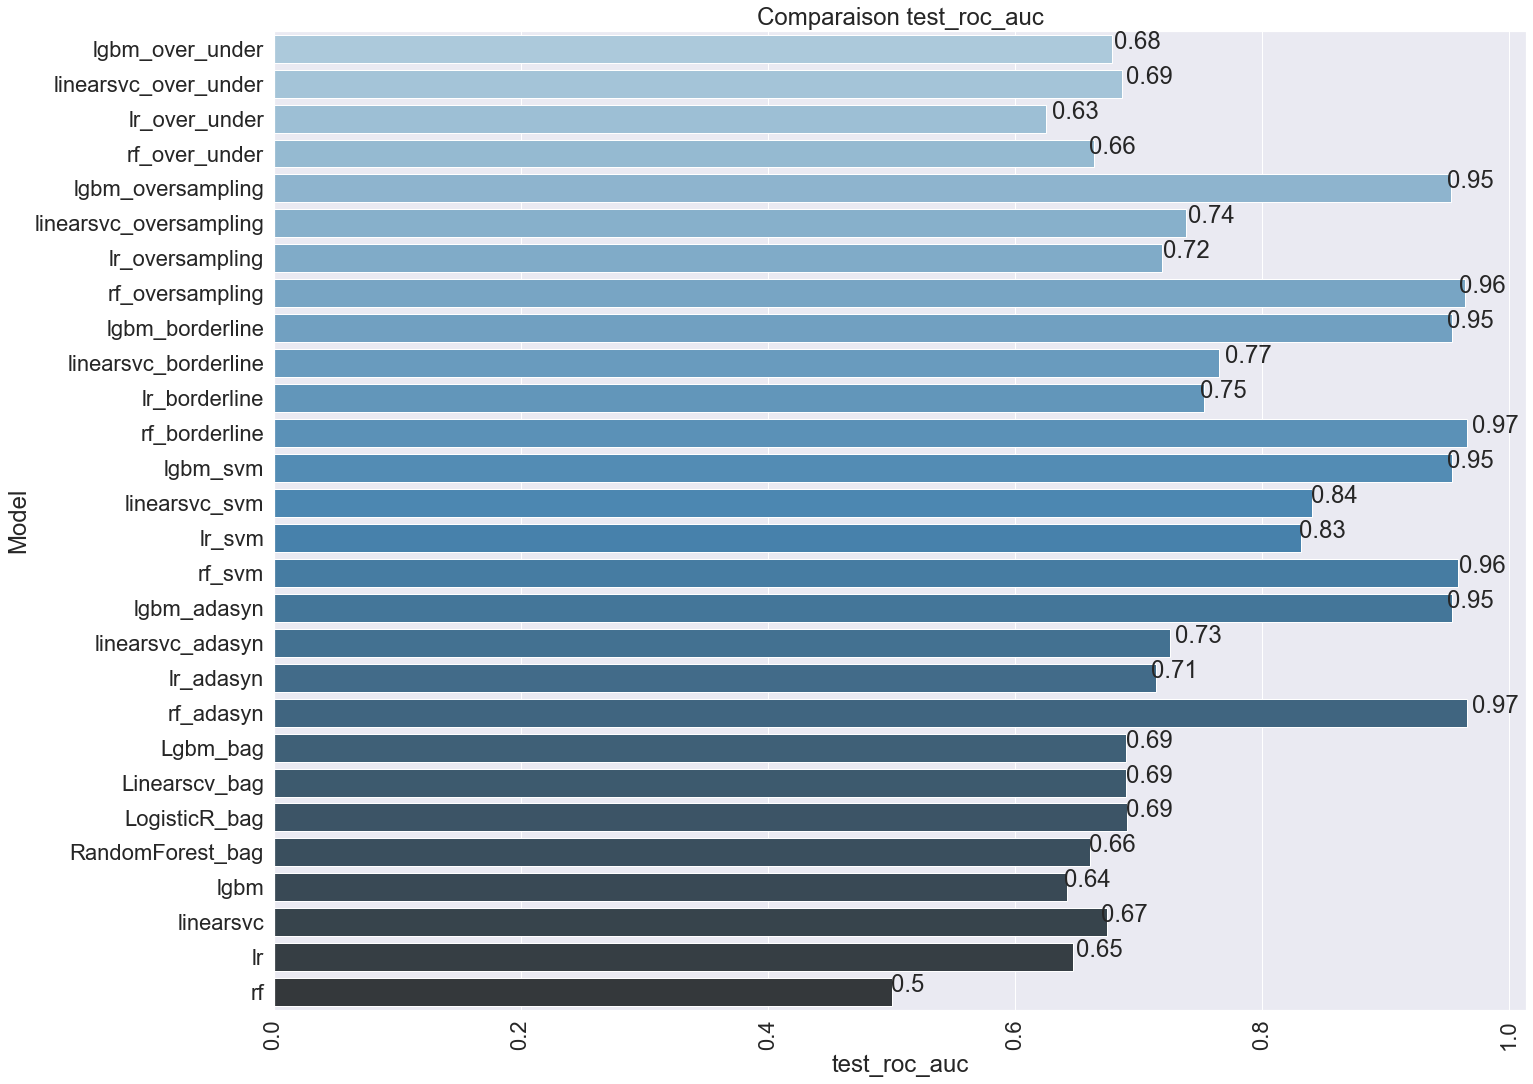

In [78]:
plt.figure(figsize=(20, 18))
sns.set(font_scale=2)
g = sns.barplot(x='test_roc_auc', y='Model',orient='h', data=res_compare, palette="Blues_d")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)for index, value in enumerate(y):
plt.title("Comparaison test_roc_auc")
plt.setp(g.get_xticklabels(), rotation=90)
for index, value in enumerate(round(res_compare.test_roc_auc,2)):
    plt.text(value, index, str(value))
plt.show()

+ #### Compare My score costumize

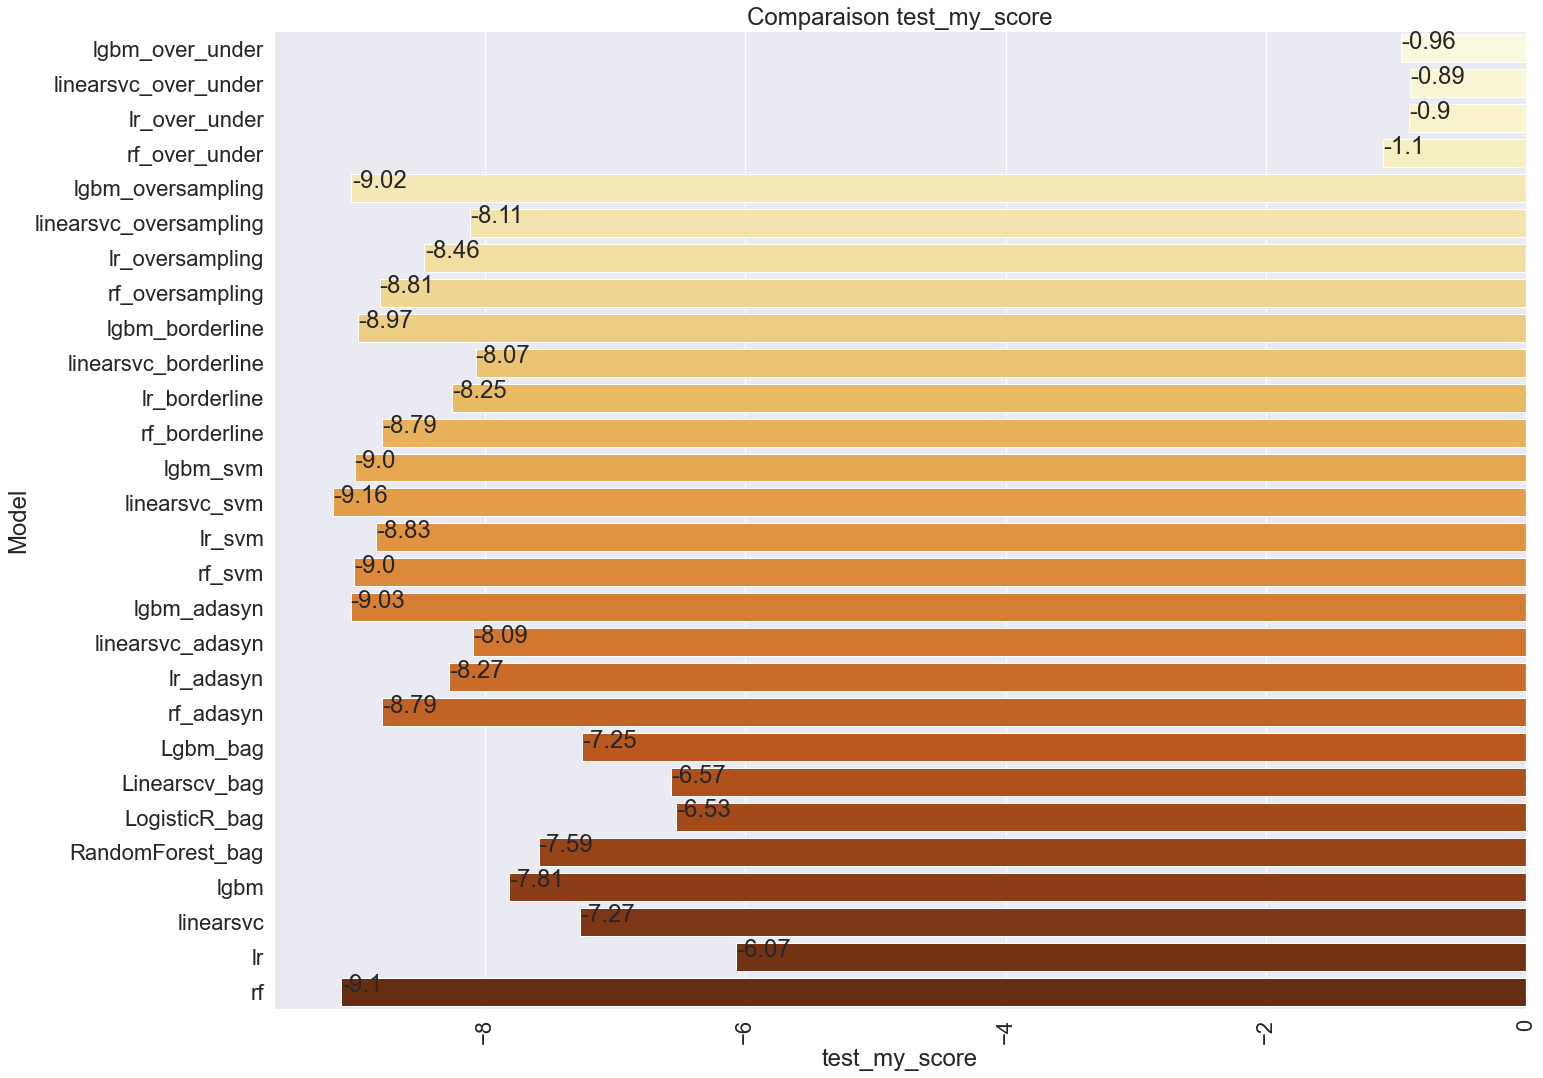

In [83]:
plt.figure(figsize=(20, 18))
sns.set(font_scale=2)
g = sns.barplot(x='test_my_score', y='Model',orient='h', data=res_compare, palette="YlOrBr")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Comparaison test_my_score")
plt.setp(g.get_xticklabels(), rotation=90)
for index, value in enumerate(round(res_compare.test_my_score,2)):
    plt.text(value, index, str(value))
plt.show()

In [100]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(15,8))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("lime")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()
def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

+ ### Logistic regression with selected features:

In [22]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X_train_final)
chi_selector = SelectKBest(chi2)
chi_selector.fit(X_norm, y_train)

SelectKBest(score_func=<function chi2 at 0x000002BF0ABCF558>)

In [23]:
chi_support = chi_selector.get_support()
chi_feature = X_train_final.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

10 selected features


In [24]:
chi_feature

['REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'PREV_NAME_CONTRACT_STATUS_Refused',
 'PREV_CODE_REJECT_REASON_HC',
 'CODE_GENDER_M',
 'NAME_EDUCATION_TYPE_Higher_education',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low_skill_Laborers']

In [25]:
clf = SGDClassifier(penalty='l1',class_weight = 'balanced', loss='log', random_state=28)

In [26]:
rfe_selector = RFE(estimator=clf, step=10, verbose=5)
rfe_selector.fit(X_norm, y_train)

Fitting estimator with 500 features.
Fitting estimator with 490 features.
Fitting estimator with 480 features.
Fitting estimator with 470 features.
Fitting estimator with 460 features.
Fitting estimator with 450 features.
Fitting estimator with 440 features.
Fitting estimator with 430 features.
Fitting estimator with 420 features.
Fitting estimator with 410 features.
Fitting estimator with 400 features.
Fitting estimator with 390 features.
Fitting estimator with 380 features.
Fitting estimator with 370 features.
Fitting estimator with 360 features.
Fitting estimator with 350 features.
Fitting estimator with 340 features.
Fitting estimator with 330 features.
Fitting estimator with 320 features.
Fitting estimator with 310 features.
Fitting estimator with 300 features.
Fitting estimator with 290 features.
Fitting estimator with 280 features.
Fitting estimator with 270 features.
Fitting estimator with 260 features.


RFE(estimator=SGDClassifier(class_weight='balanced', loss='log', penalty='l1',
                            random_state=28),
    step=10, verbose=5)

In [28]:
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_final.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

250 selected features


In [29]:
col_lr=[]
for val in rfe_feature:
    col_lr.append(val)
print('Nombre de colonnes:', str(len(col_lr)))    

Nombre de colonnes: 250


In [30]:
from sklearn.feature_selection import SelectFromModel

embeded_lr_selector = SelectFromModel(clf)
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature =X_train_final.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

231 selected features


In [31]:
col_lr1=[]
for val in embeded_lr_feature:
    col_lr1.append(val)
print('Nombre de colonnes:', str(len(col_lr1)))   

Nombre de colonnes: 231


+ ### Optimisation parameters

+ #### Logistique Regression Optimize

*Optimisation avec GridSearchCV*

In [33]:
scoring = {'auc':make_scorer(roc_auc_score, average='weighted'),
           'my_score': make_scorer(my_score, greater_is_better=False)
          }


param_test ={'alpha': np.logspace(-4,4,9),
             'class_weight':['balanced',None,'subsample_balanced',{0:1,1:11},{0:1,1:14},{0:1,1:20}],
             'penalty':['l2', 'l1', 'elasticnet']
            }



cv = model_selection.StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
clf = SGDClassifier(loss='log', random_state=28)
clf_grid = GridSearchCV(clf,param_grid=param_test,scoring=scoring,cv=cv,refit='auc',verbose=True,n_jobs=-1)
clf_grid.fit(X_train_final[selected_features], y_train)
print('Best params: {} '.format(clf_grid.best_params_))
print('Best score: {} '.format(clf_grid.best_score_))

Fitting 7 folds for each of 162 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  2.2min finished


Best params: {'alpha': 0.01, 'class_weight': {0: 1, 1: 14}, 'penalty': 'elasticnet'} 
Best score: 0.6930195744778082 


*Optimisation sans GridSearchCV*

For alpha 0.0001, cross validation AUC score 0.7278687591683949
For alpha 0.001, cross validation AUC score 0.7439438009003996
For alpha 0.01, cross validation AUC score 0.7423895998785979
For alpha 0.1, cross validation AUC score 0.718935580960089
For alpha 1.0, cross validation AUC score 0.5
For alpha 10.0, cross validation AUC score 0.5
For alpha 100.0, cross validation AUC score 0.5
For alpha 1000.0, cross validation AUC score 0.5
For alpha 10000.0, cross validation AUC score 0.5


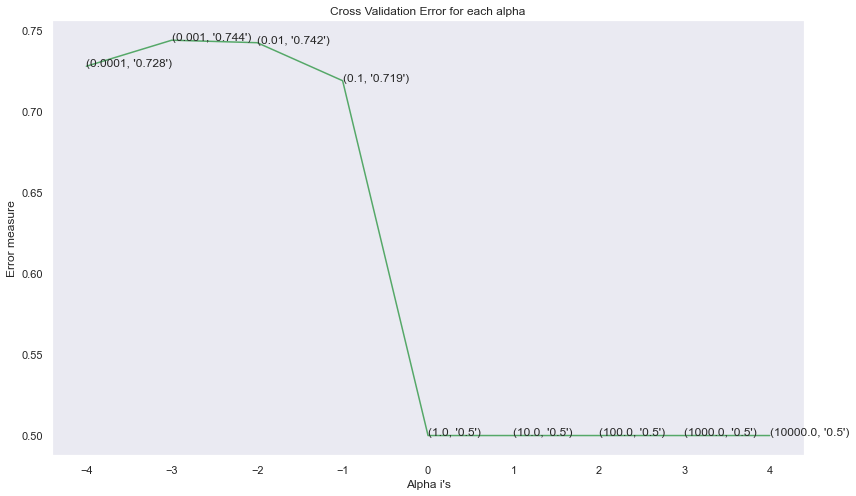

The Optimal C value is: 0.001


In [34]:
alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train_final[selected_features], y_train)
    cv = model_selection.StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid',cv=cv)
    sig_clf.fit(X_train_final[selected_features], y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
sns.set(font_scale=1.0)
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])

For best alpha 0.001, The Train AUC score is 0.7765110982400782
For best alpha 0.001, The Cross validated AUC score is 0.7449067985229401
For best alpha 0.001, The Test AUC score is 0.734001541531339
The test AUC score is : 0.734001541531339
The percentage of misclassified points 36.96% :
My score Costumize: 17.2895


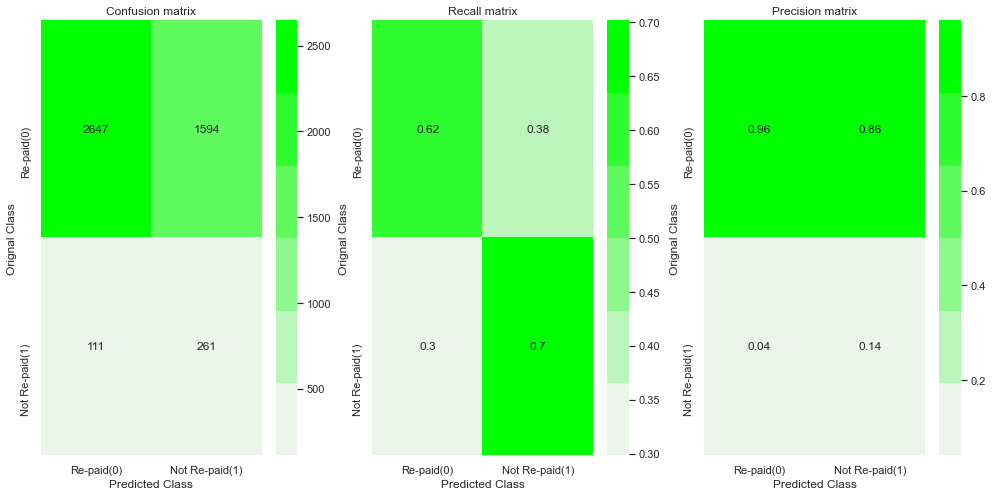

In [38]:
#best_alpha =  0.001

logreg = SGDClassifier(alpha= 0.01, class_weight={0: 1, 1: 14},
                       penalty='elasticnet', loss='log', random_state=28)

logreg.fit(X_train_final[selected_features], y_train)
#cv = model_selection.StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid',cv=7)

logreg_sig_clf.fit(X_train_final[selected_features], y_train)

y_pred_prob = logreg_sig_clf.predict_proba(
    X_train_final[selected_features])[:, 1]

print('For best alpha {0}, The Train AUC score is {1}'.format(
    best_alpha, roc_auc_score(y_train, y_pred_prob)))

y_pred_prob = logreg_sig_clf.predict_proba(
    X_val_final[selected_features])[:, 1]

print('For best alpha {0}, The Cross validated AUC score is {1}'.format(
    best_alpha, roc_auc_score(y_val, y_pred_prob)))

y_pred_prob = logreg_sig_clf.predict_proba(
    X_test_final[selected_features])[:, 1]

print('For best alpha {0}, The Test AUC score is {1}'.format(
    best_alpha, roc_auc_score(y_test, y_pred_prob)))

y_pred = logreg.predict(X_test_final[selected_features])

print('The test AUC score is :', roc_auc_score(y_test, y_pred_prob))


print('The percentage of misclassified points {:05.2f}% :'.format(
    (1-accuracy_score(y_test, y_pred))*100))
print('My score Costumize:',my_score(y_test,y_pred))
plot_confusion_matrix(y_test, y_pred)

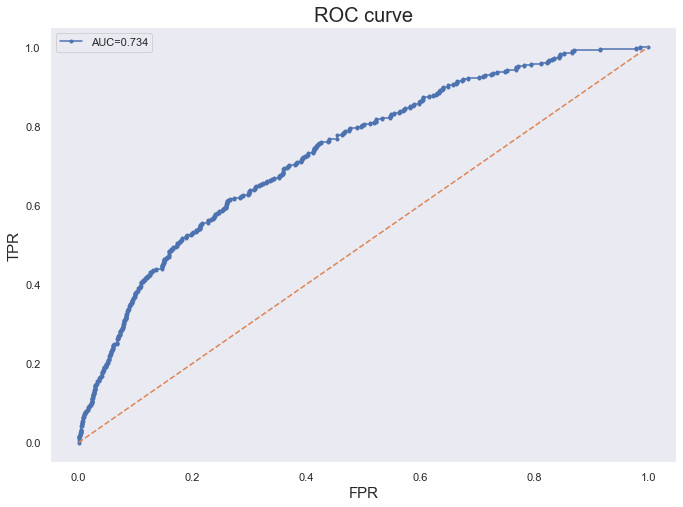

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

+ ### LgbmClassifier

In [96]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import cross_val_score

*Avant Optimisation*

In [91]:
myscore = make_scorer(my_score, greater_is_better=False)

In [153]:
lgbm = lgb.LGBMClassifier(random_state=42,class_weight='balanced')
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
scores = cross_val_score(lgbm, X_train_final[selected_features], y_train, scoring='roc_auc', cv=cv,n_jobs=-1)
scores1 = cross_val_score(lgbm, X_val_final[selected_features], y_val, scoring='roc_auc', cv=cv,n_jobs=-1)
scores2 = cross_val_score(lgbm, X_test_final[selected_features], y_test, scoring='roc_auc', cv=cv,n_jobs=-1)
print('Mean AUC: %.3f' % np.mean(scores))
print('Mean AUC: %.3f' % np.mean(scores1))
print('Mean AUC: %.3f' % np.mean(scores2))
lgbm.fit(X_train_final[selected_features], y_train)
predict_lgbm_v2 = lgbm.predict(X_val_final[selected_features])
predict_prob_lgbm=lgbm.predict_proba(X_val_final[selected_features])
print(classification_report(y_val,predict_lgbm_v2))
pd.DataFrame(confusion_matrix(y_val,predict_lgbm_v2,normalize='true'))
##################################################
predict_test=lgbm.predict(X_test_final[selected_features])
print(classification_report(y_test,predict_test))
print('My score Costumize Train:',myscore(lgbm,X_train_final[selected_features], y_train))
print('My score Costumize Valid:',myscore(lgbm,X_val_final[selected_features], y_val))
print('My score Costumize Test:',myscore(lgbm,X_test_final[selected_features],y_test))
predict_prob_test=lgbm.predict_proba(X_test_final[selected_features])
pd.DataFrame(confusion_matrix(y_test,predict_test,normalize='true'))

Mean AUC: 0.742
Mean AUC: 0.710
Mean AUC: 0.702
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      4240
           1       0.20      0.46      0.28       373

    accuracy                           0.81      4613
   macro avg       0.57      0.65      0.58      4613
weighted avg       0.89      0.81      0.84      4613

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      4241
           1       0.20      0.45      0.28       372

    accuracy                           0.81      4613
   macro avg       0.57      0.65      0.58      4613
weighted avg       0.89      0.81      0.84      4613

My score Costumize Train: -53.4965
My score Costumize Valid: -11.5175
My score Costumize Test: -11.553


0         1
0  0.841311  0.158689
1  0.551075  0.448925

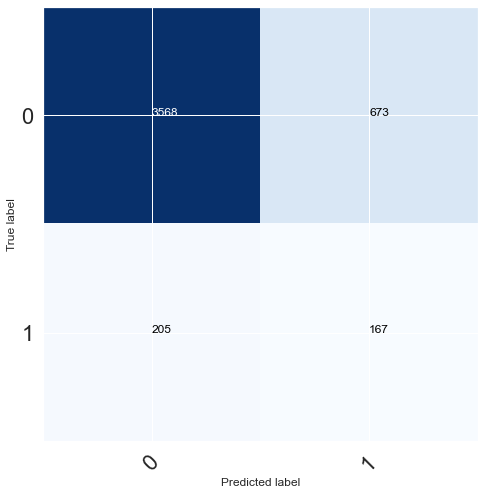

In [154]:
pretty_print_conf_matrix(y_test,predict_test,classes=['0','1'])

*Optimisation*

In [17]:
scoring = {'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted'),
           'my_score': make_scorer(my_score, greater_is_better=False),
           'precision': make_scorer(precision_score, average='weighted'),
           'auc':make_scorer(roc_auc_score, average='weighted')
           }


fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X_val_final[selected_features],y_val)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'
             }

param_test = {
              'learning_rate' :[0.04,0.07,0.01,0.1,0.2],
              'min_split_gain':[0,0.01,0.1,0.3,0.5,0.7],
              'num_leaves': [int(x) for x in np.linspace(start = 25, stop = 40, num = 1)],
              'min_child_samples': [int(x) for x in np.linspace(start = 15, stop = 25, num = 1)],
              'min_child_weight': [1e-4,1e-3,1,1e1,30,50],
              'subsample': [0.5,0.8,1.0,1.5,2.0], 
              'max_depth': [7,10,None],
              'colsample_bytree': [0.7,0.9,1.0,2.0],
              'scale_pos_weight':[int(x) for x in np.linspace(start = 1, stop = 12, num = 1)],
              #'reg_alpha':[int(x) for x in np.linspace(start = 18, stop = 25, num = 1)],
              #'reg_lambda':[int(x) for x in np.linspace(start = 18, stop = 25, num = 1)],
              'class_weight':['balanced',None,{0:1,1:11},{0:1,1:14}]
              }


clf1 = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',max_bin= 512,n_estimators=200,subsample_for_bin=200,
                         subsample_freq=1, random_state=42, silent=True, metric='None',reg_alpha=20,reg_lambda=20)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=clf1, param_grid=param_test,scoring=scoring,cv=cv,refit='my_score',verbose=True,n_jobs=-1)

grid_search.fit(X_train_final[selected_features], y_train, **fit_params)
print('Best params: {} '.format(grid_search.best_params_))

opt_parameters =  grid_search.best_params_

In [232]:
grid_search.best_params_

{'class_weight': 'balanced',
 'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'min_child_samples': 8,
 'min_split_gain': 0,
 'n_estimators': 200,
 'num_leaves': 27,
 'scale_pos_weight': 10}

In [216]:
grid_search.best_params_

{'class_weight': 'balanced',
 'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_samples': 8,
 'min_child_weight': 0.001,
 'min_split_gain': 0,
 'n_estimators': 200,
 'num_leaves': 27,
 'scale_pos_weight': 10,
 'subsample': 0.5}

In [41]:
grid_search.best_params_

{'class_weight': None,
 'colsample_bytree': 0.8,
 'is_unbalance': False,
 'learning_rate': 0.04,
 'max_depth': 3,
 'min_child_samples': 10,
 'min_child_weight': 0.1,
 'n_estimators': 700,
 'num_leaves': 28,
 'scale_pos_weight': 10,
 'subsample': 0.6}

In [ ]:
#Best params

In [ ]:
class_weight= {0: 1, 1: 11},
 colsample_bytree= 0.9,
 is_unbalance= True,
 learning_rate= 0.04,
 max_depth= 10,
 min_child_samples= 10,
 min_child_weight= 10.0,
 n_estimators= 200,
 num_leaves=29,
 scale_pos_weight=10,
 subsample= 0.6

In [ ]:
{'class_weight': {0: 1, 1: 14},
 'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_samples': 5,
 'min_child_weight': 10.0,
 'min_split_gain': 0.5,
 'n_estimators': 200,
 'num_leaves': 20,
 'scale_pos_weight': 1,
 'subsample': 1.0}

In [97]:
clf1 = lgb.LGBMClassifier(boosting_type='gbdt', min_split_gain=0.5, subsample_for_bin=200,
                          subsample_freq=1, objective='binary', max_bin=512,
                          random_state=42, silent=True, reg_alpha=20, reg_lambda=20,
                          colsample_bytree= 0.9,
                          learning_rate=0.04,
                          max_depth=8,
                          min_child_samples=5,
                          min_child_weight=10.0,
                          n_estimators=200,
                          num_leaves=27,
                          scale_pos_weight=2,
                          subsample=1.0,
                          class_weight= {0: 1, 1: 14},
                         )

In [98]:
scoring = {'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted'),
           'my_score': make_scorer(my_score, greater_is_better=False),
           'precision': make_scorer(precision_score, average='weighted'),
           'auc':make_scorer(roc_auc_score, average='weighted')
           }

In [99]:
#clf1 = lgb.LGBMClassifier(**opt_parameters)
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
scores = cross_val_score(clf1, X_train_final[selected_features], y_train, scoring='roc_auc', cv=cv,n_jobs=-1)
scores1 = cross_val_score(clf1, X_val_final[selected_features], y_val, scoring='roc_auc', cv=cv,n_jobs=-1)
scores2 = cross_val_score(clf1, X_test_final[selected_features], y_test, scoring='roc_auc', cv=cv,n_jobs=-1)
print('Mean AUC: %.3f' % np.mean(scores))
print('Mean AUC: %.3f' % np.mean(scores1))
print('Mean AUC: %.3f' % np.mean(scores2))
clf1.fit(X_train_final[selected_features], y_train)
predict_lgbm_v2 = clf1.predict(X_val_final[selected_features])
predict_prob_lgbm=clf1.predict_proba(X_val_final[selected_features])
print(classification_report(y_val,predict_lgbm_v2))
pd.DataFrame(confusion_matrix(y_val,predict_lgbm_v2,normalize='true'))
##################################################
predict_test=clf1.predict(X_test_final[selected_features])
print(classification_report(y_test,predict_test))
print('My score Costumize Train:',myscore(clf1,X_train_final[selected_features], y_train))
print('My score Costumize Valid:',myscore(clf1,X_val_final[selected_features], y_val))
print('My score Costumize Test:',myscore(clf1,X_test_final[selected_features],y_test))
predict_prob_test=clf1.predict_proba(X_test_final[selected_features])
pd.DataFrame(confusion_matrix(y_test,predict_test,normalize='true'))

Mean AUC: 0.755
Mean AUC: 0.740
Mean AUC: 0.714
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      4240
           1       0.14      0.80      0.24       373

    accuracy                           0.59      4613
   macro avg       0.55      0.68      0.48      4613
weighted avg       0.90      0.59      0.68      4613

              precision    recall  f1-score   support

           0       0.96      0.57      0.72      4241
           1       0.13      0.75      0.23       372

    accuracy                           0.59      4613
   macro avg       0.55      0.66      0.47      4613
weighted avg       0.90      0.59      0.68      4613

My score Costumize Train: -39.584
My score Costumize Valid: -8.3575
My score Costumize Test: -8.4305


0         1
0  0.573450  0.426550
1  0.247312  0.752688

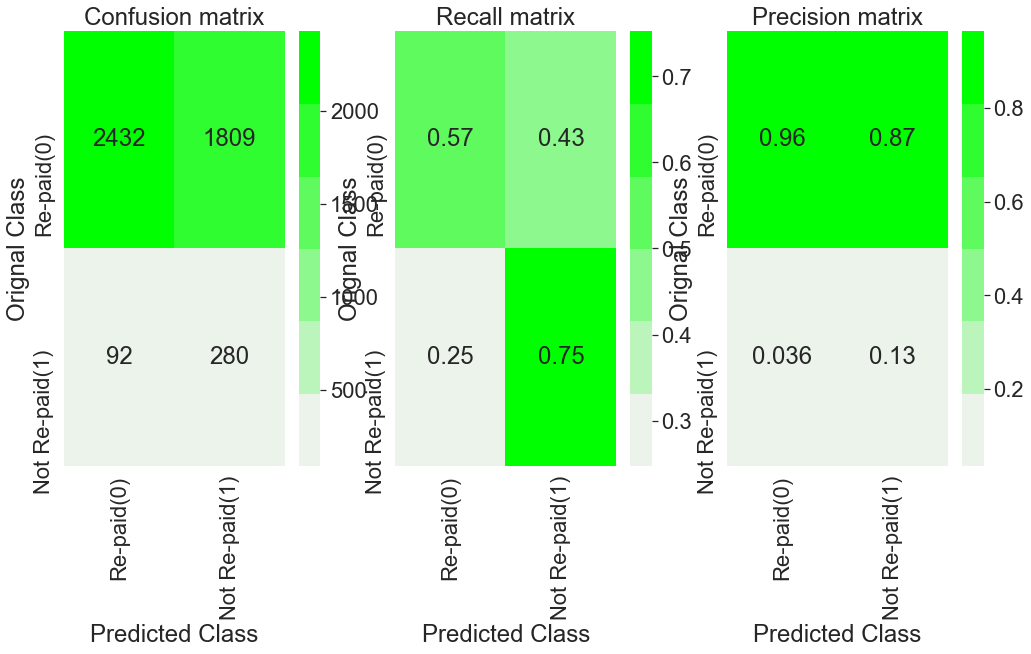

In [101]:
plot_confusion_matrix(y_test, predict_test)

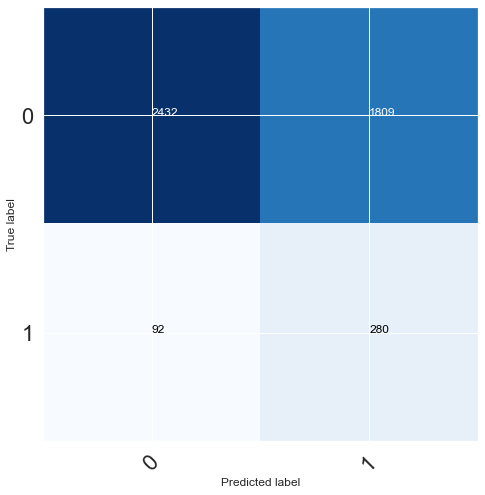

In [102]:
pretty_print_conf_matrix(y_test, predict_test,classes=['0', '1'])

In [57]:
import joblib

In [53]:
# save
joblib.dump(clf1, 'my_model.pkl') 

['my_model.pkl']

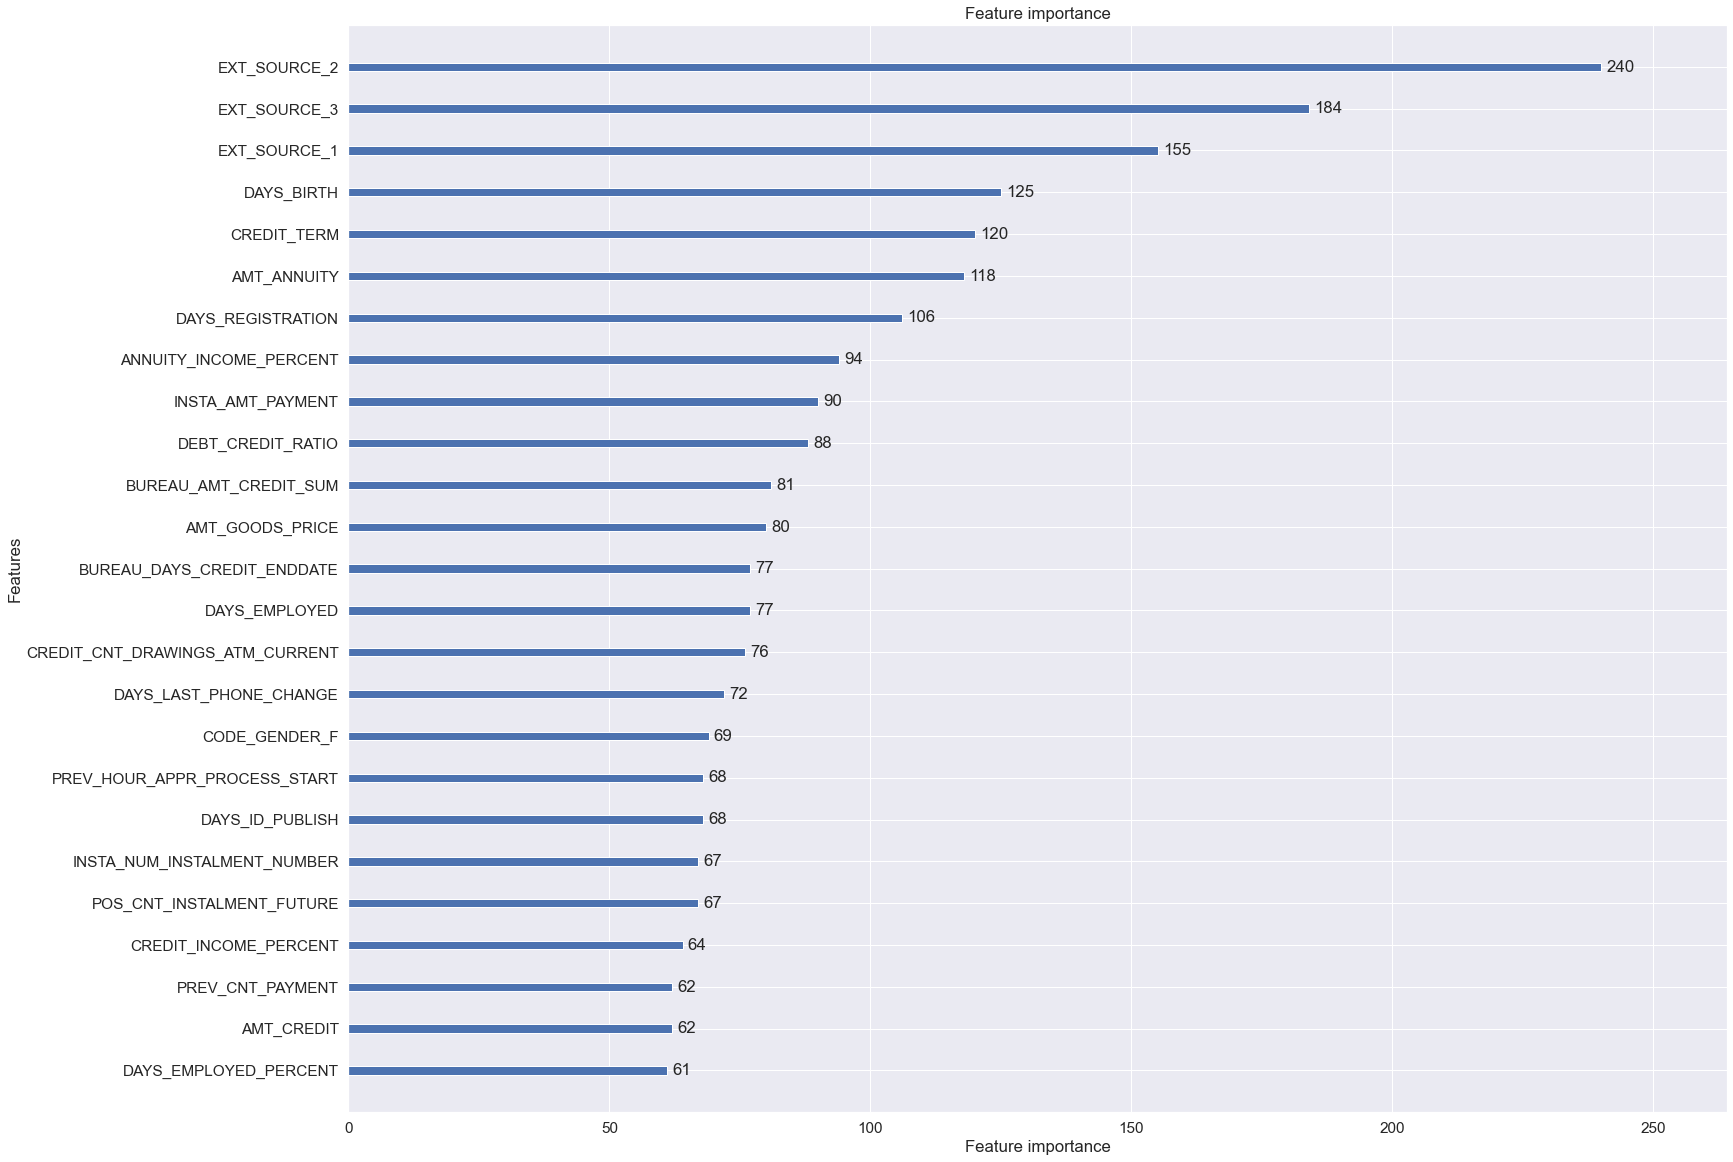

In [103]:
sns.set(font_scale=1.4)
lgb.plot_importance(clf1, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance',
                    ylabel='Features', importance_type='split', max_num_features=25, ignore_zero=True, figsize=(22, 20), dpi=None, grid=True, precision=3)
plt.show()

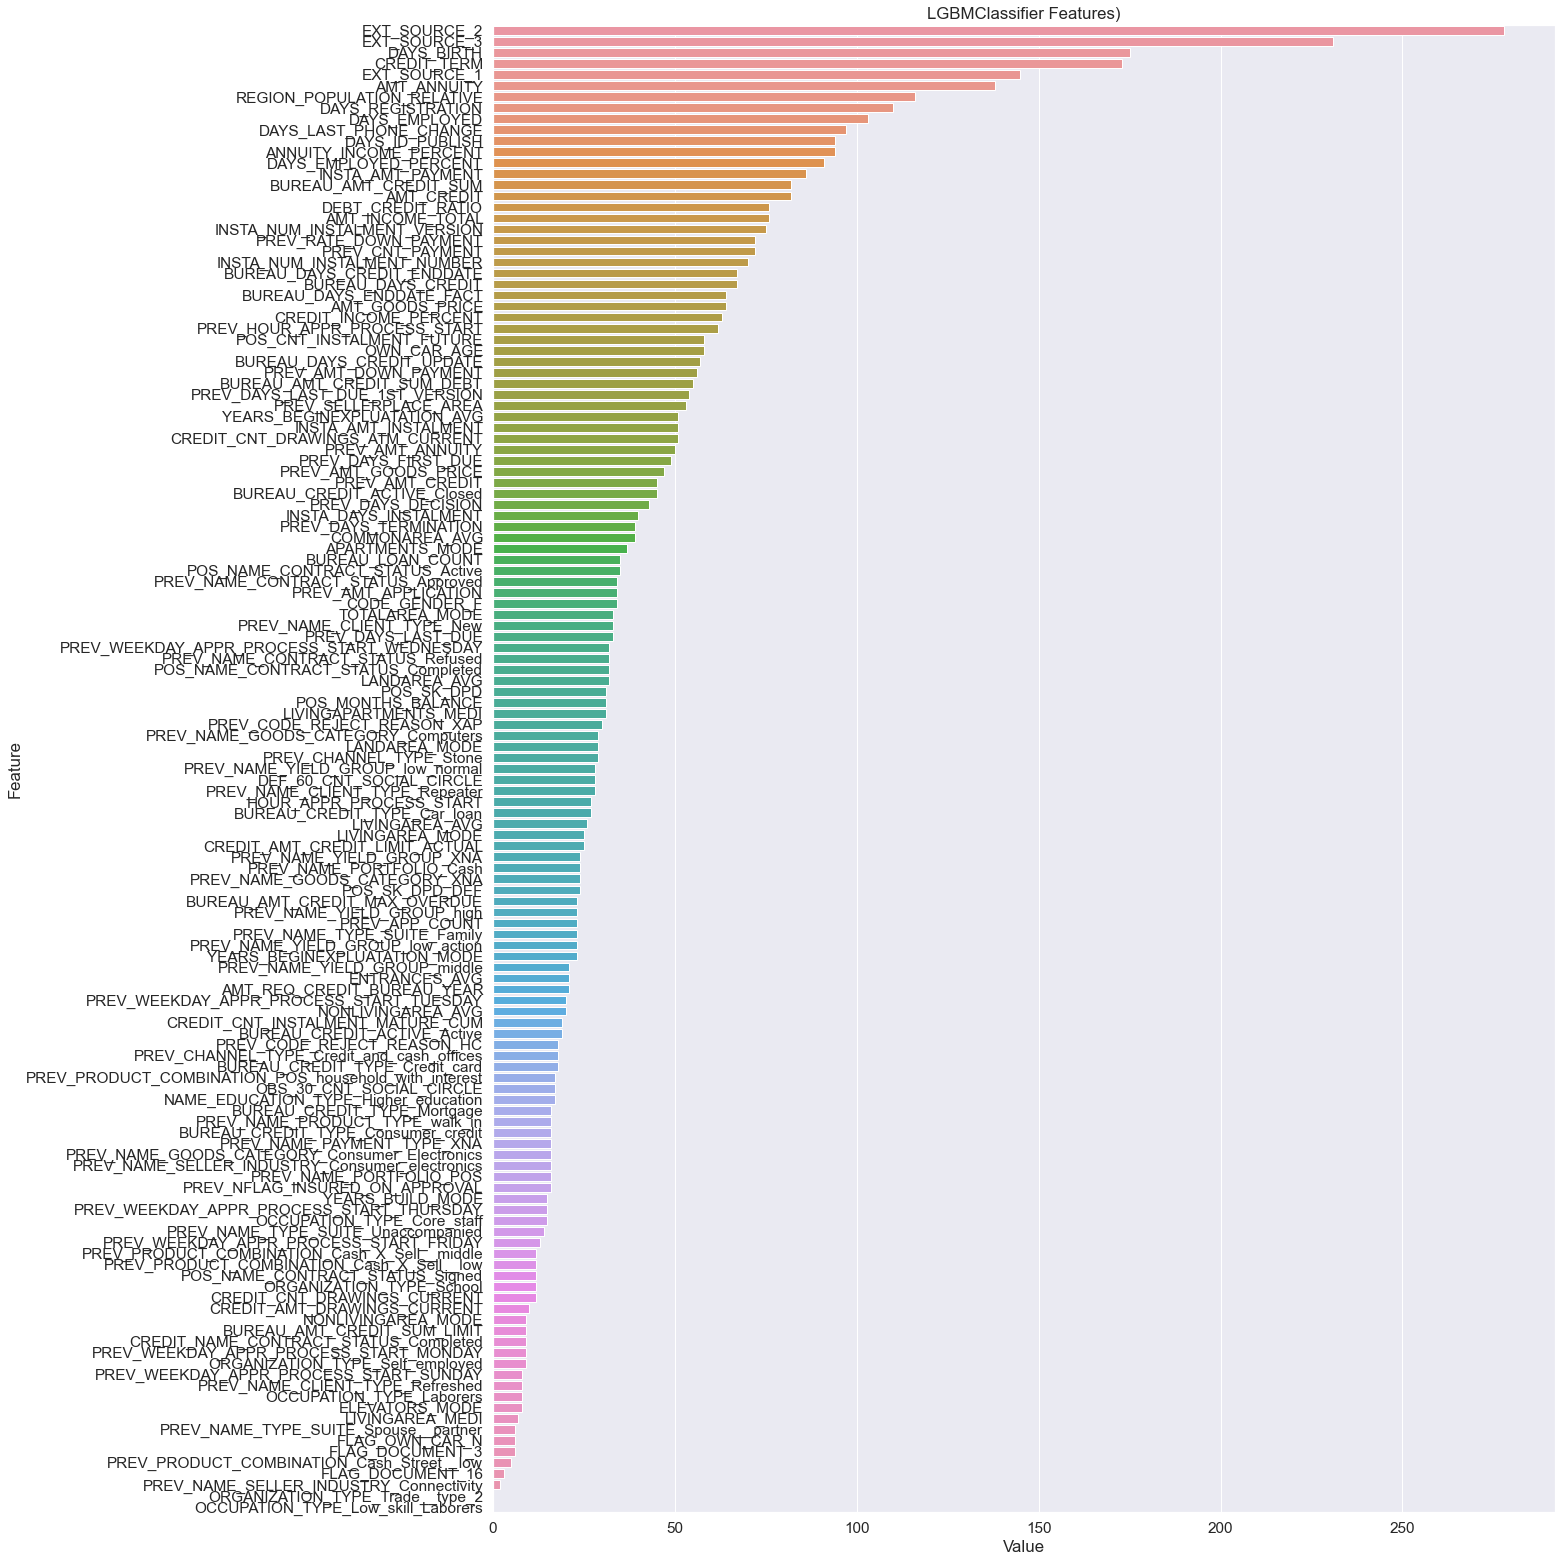

In [50]:
feature_imp = pd.DataFrame(sorted(zip(clf1.feature_importances_,X_val_final[selected_features].columns)), columns=['Value','Feature'])

plt.figure(figsize=(22, 22))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBMClassifier Features)')
plt.tight_layout()
plt.show()

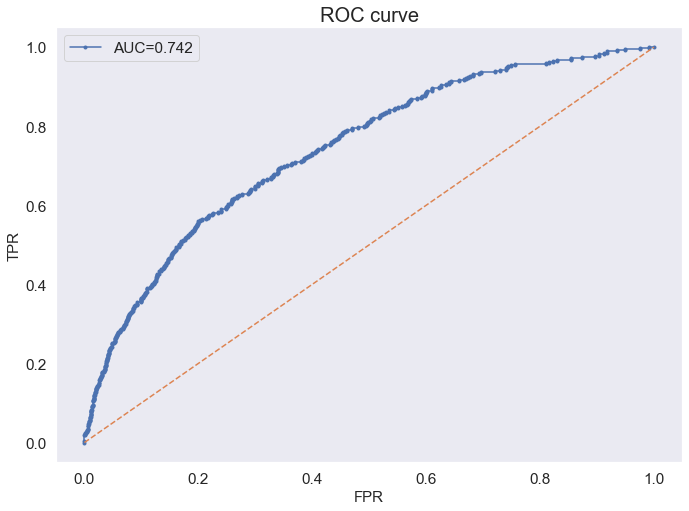

In [104]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, predict_prob_test[:,1])
auc = roc_auc_score(y_test,predict_prob_test[:,1])
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [162]:
data_essa=X_test_final[selected_features].copy()

In [163]:
data_essa['predict']=predict_test

In [164]:
data_essa['proba']=predict_prob_test[:,1]

In [165]:
data_essa[['predict','proba']]

predict     proba
SK_ID_CURR                   
455822            1  0.858908
426066            1  0.701474
160231            0  0.438578
226218            0  0.353603
226165            1  0.803912
...             ...       ...
393064            0  0.316953
410927            0  0.410414
266642            1  0.503207
239826            0  0.295907
366161            1  0.725292

[4613 rows x 2 columns]

*Optimization sans GridSearchCV*

In [53]:
weight = np.ones((len(X_train_final),), dtype=int)
for y in y_train:

    if y == 0:

        weight[y] = 1

    else:

        weight[y] = 11.37
        
train_data = lgb.Dataset(X_train_final[selected_features],
                         label=y_train, weight=weight, categorical_feature='auto')
valid_data = lgb.Dataset(
    X_val_final[selected_features], label=y_val, categorical_feature='auto')

cv_auc_score = []
max_depth = [3,7,10]
for i in max_depth:
    params = {'boosting_type': 'gbdt',
              'max_depth': i,
              'objective': 'binary',
              'nthread': 5,
              'num_leaves': 32,
              'learning_rate': 0.05,
              'max_bin': 512,
              'subsample_for_bin': 200,
              'subsample': 0.7,
              'subsample_freq': 1,
              'colsample_bytree': 0.8,
              'reg_alpha': 20,
              'reg_lambda': 20,
              'min_split_gain': 0.5,
              'min_child_weight': 1,
              'min_child_samples': 10,
              'scale_pos_weight': 20,
              'num_class': 1,
              'metric': 'auc'
              }
    lgbm = lgb.train(params,
                     train_data,
                     2500,
                     valid_sets=valid_data,
                     early_stopping_rounds=100,
                     verbose_eval=10
                     )
    y_pred_prob = lgbm.predict(X_val_final[selected_features])
    cv_auc_score.append(roc_auc_score(y_val, y_pred_prob))
    print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(
        i, roc_auc_score(y_val, y_pred_prob)))

    print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 1737, number of negative: 19788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3935
[LightGBM] [Info] Number of data points in the train set: 21525, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080659 -> initscore=-2.433421
[LightGBM] [Info] Start training from score -2.433421
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Info] Number of positive: 1737, number of negative: 19788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3935
[LightGBM] [Info] Number of data points in the train set: 21525, number of used features: 135
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080659 -> initscore=-2.433421
[LightGBM] [Info] Start training from score -2.433421
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's auc: 0.726125
[LightGBM] [Warning] No further split

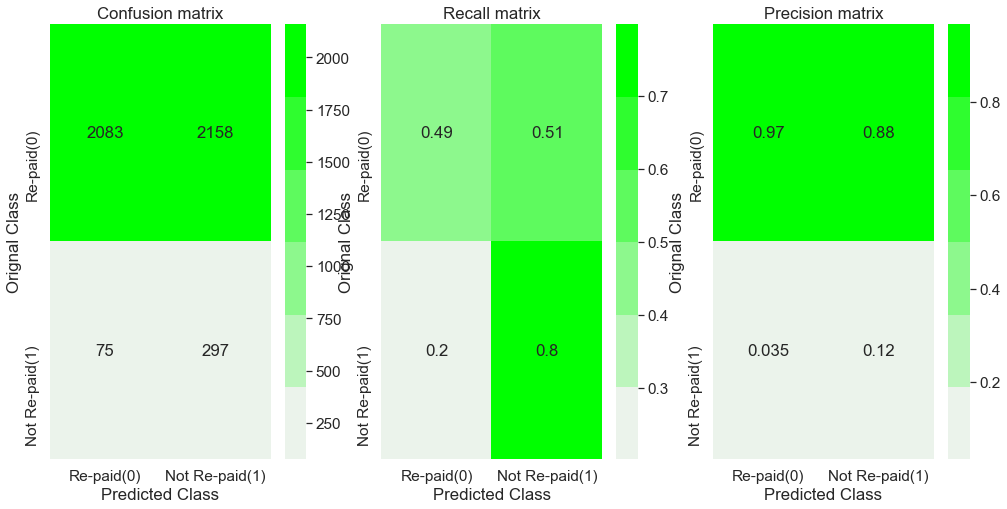

In [54]:
params = {'boosting_type': 'gbdt',
          'max_depth': max_depth[np.argmax(cv_auc_score)],
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 20,
          'num_class': 1,
          'metric': 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds=100,
                 verbose_eval=10
                 )
y_pred_prob = lgbm.predict(X_train_final[selected_features])
print('For best max_depth {0}, The Train AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)],
                                                                  roc_auc_score(y_train, y_pred_prob)))
y_pred_prob = lgbm.predict(X_val_final[selected_features])
print('For best max_depth {0}, The Cross validated AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)],
                                                                            roc_auc_score(y_val, y_pred_prob)))
y_pred_prob = lgbm.predict(X_test_final[selected_features])
print('For best max_depth {0}, The Test AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)],
                                                                 roc_auc_score(y_test, y_pred_prob)))
y_pred = np.ones((len(X_test_final),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i] <= 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
X_test_final2=X_test_final[selected_features].copy()  
X_test_final2['predict']=y_pred_prob
print('The test AUC score is :', roc_auc_score(y_test, y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

In [57]:
X_test_final2

EXT_SOURCE_2  EXT_SOURCE_3  EXT_SOURCE_1  CREDIT_TERM  DAYS_BIRTH  \
SK_ID_CURR                                                                      
455822         -0.236833     -1.258034     -3.097899    -0.884419    1.499427   
426066         -1.029748      0.112266      0.009506    -0.115227    1.186298   
160231          0.586875     -0.805189      0.825054     1.078956    1.486801   
226218          1.243818      0.467698     -1.337991    -0.212614    0.993462   
226165         -2.056156      0.112266      0.009506    -1.150379    0.953058   
...                  ...           ...           ...          ...         ...   
393064          0.756416     -1.005586      0.009506    -0.558377   -0.218421   
410927          1.254262     -0.208485     -1.437628    -0.212614    0.497598   
266642          0.662508     -0.485950      2.809748    -0.271548    0.383733   
239826          0.493806     -0.063483      0.009506    -0.327151   -0.612358   
366161          0.161861     -1.716204      0.009506    -1.557925   -1.153676   

            CREDIT_CNT_DRAWINGS_ATM_CURRENT  AMT_ANNUITY  \
SK_ID_CURR                                                 
455822                            -0.246783     0.233479   
426066                            -0.246783    -1.569515   
160231                            -0.246783     0.690099   
226218                            -0.246783    -0.008710   
226165                             1.474191     2.071246   
...                                     ...          ...   
393064                            -0.246783    -0.723380   
410927                             0.590342    -0.923780   
266642                             1.172690     1.716504   
239826                            -0.246783    -0.724295   
366161                            -0.246783    -0.013895   

            CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  AMT_INCOME_TOTAL  \
SK_ID_CURR                                                                    
455822                   0.007475                0.932982         -0.579687   
426066                  -1.249724               -1.582884         -0.340695   
160231                   1.615083                0.980809         -0.340695   
226218                  -0.487174               -0.504181          0.376282   
226165                  -0.875918               -0.557580          3.005198   
...                           ...                     ...               ...   
393064                   0.086619                0.642698         -1.057672   
410927                  -0.801950               -0.944635         -0.197299   
266642                  -0.631661               -0.678324          3.005198   
239826                  -0.736724               -0.804571         -0.101702   
366161                  -0.779190                0.182078         -0.340695   

            DAYS_EMPLOYED  AMT_CREDIT  DAYS_ID_PUBLISH  DAYS_EMPLOYED_PERCENT  \
SK_ID_CURR                                                                      
455822           0.957549   -0.371108         0.554619              -1.044922   
426066           0.048519   -1.270314        -0.119009               0.390771   
160231           0.921790    1.280549         0.745757              -0.980769   
226218          -0.243669   -0.150887        -0.722952               0.709897   
226165          -0.302483    0.310255        -1.003685               0.767527   
...                   ...         ...              ...                    ...   
393064          -0.029115   -0.776315         1.627778              -0.115517   
410927           0.420224   -0.811550        -1.084653              -0.429311   
266642           0.069222    1.035223        -1.412508              -0.030303   
239826           0.757111   -0.703752         0.494225              -0.953390   
366161           0.455983   -0.851344        -0.537123              -0.735424   

            AMT_GOODS_PRICE  DAYS_LAST_PHONE_CHANGE  DAYS_REGISTRATION  \
SK_ID_CURR           

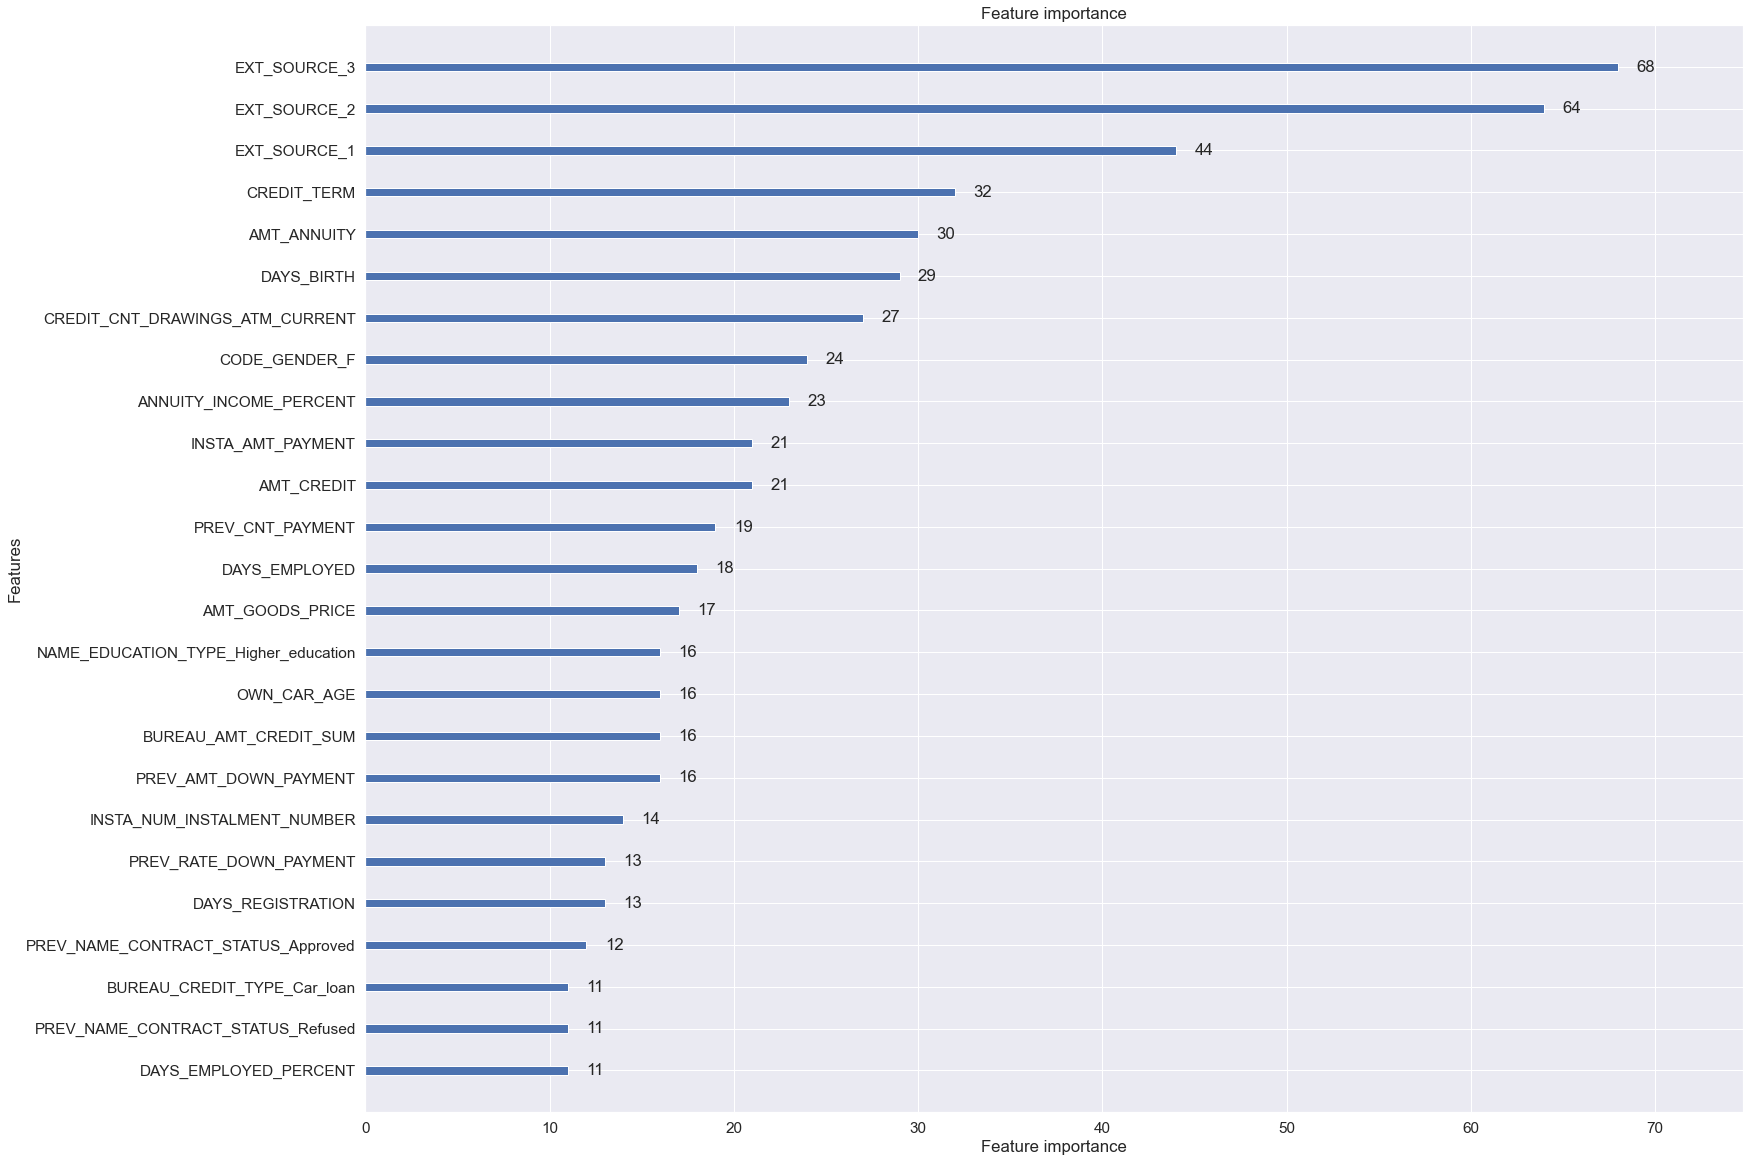

In [58]:
sns.set(font_scale=1.4)
lgb.plot_importance(lgbm, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance',
                    ylabel='Features', importance_type='split', max_num_features=25, ignore_zero=True, figsize=(22, 20), dpi=None, grid=True, precision=3)
plt.show()

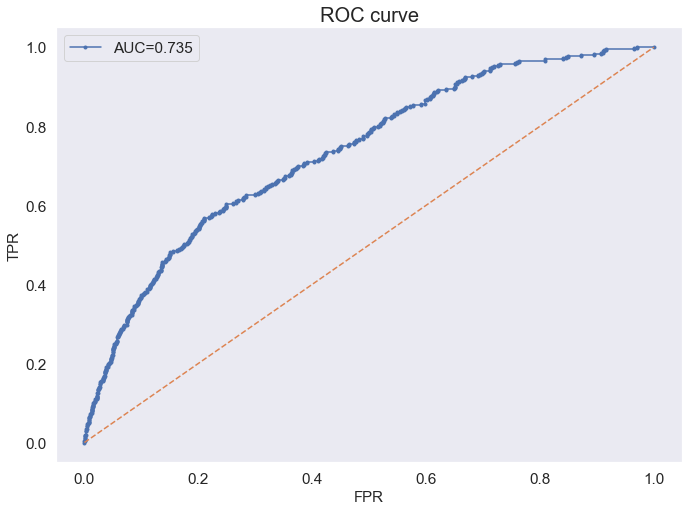

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

+ ### Interpretation model

In [105]:
import shap
shap.initjs()

In [106]:
lgbm_explainer = shap.TreeExplainer(clf1,  X_train_final[selected_features],model_output='probability',feature_dependence="independent")
shap_values =lgbm_explainer.shap_values(X_test_final[selected_features].loc[[426066]])

In [107]:
shap.force_plot(lgbm_explainer.expected_value, shap_values, X_test_final[selected_features].loc[426066])

In [108]:
joblib.dump(lgbm_explainer, "shap_model.pkl")

['shap_model.pkl']

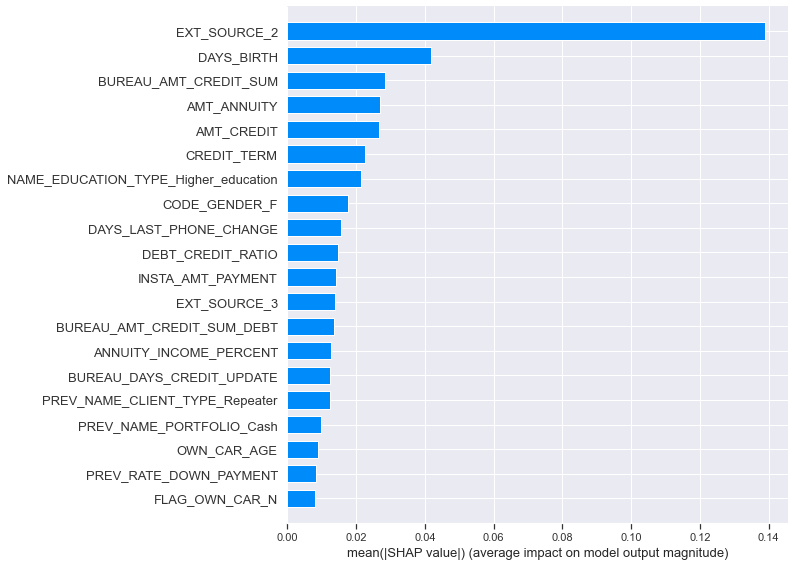

In [109]:
shap.summary_plot(shap_values, X_test_final[selected_features].loc[[426066]],plot_type='bar')

In [110]:
data_for_prediction =X_test_final[selected_features].loc[[426066]]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
clf1.predict_proba(data_for_prediction_array)

array([[0.29852599, 0.70147401]])

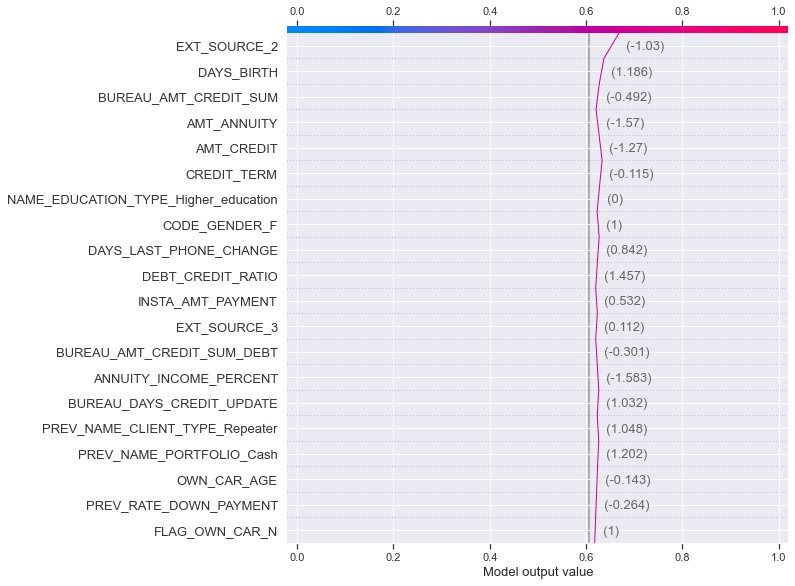

In [111]:
shap.decision_plot(
    base_value=lgbm_explainer.expected_value,
    shap_values=shap_values,
    features=X_test_final[selected_features].loc[[426066]],
    feature_names=X_test_final[selected_features].columns.tolist(),
    link="logit",
    #new_base_value=0.5
)

In [ ]:
226218

In [112]:
data_for_prediction =X_test_final[selected_features].loc[[226218]]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
clf1.predict_proba(data_for_prediction_array)

array([[0.64639731, 0.35360269]])

In [113]:
shap_values =lgbm_explainer.shap_values(X_test_final[selected_features].loc[[226218]])
shap.force_plot(lgbm_explainer.expected_value, shap_values, X_test_final[selected_features].loc[226218])

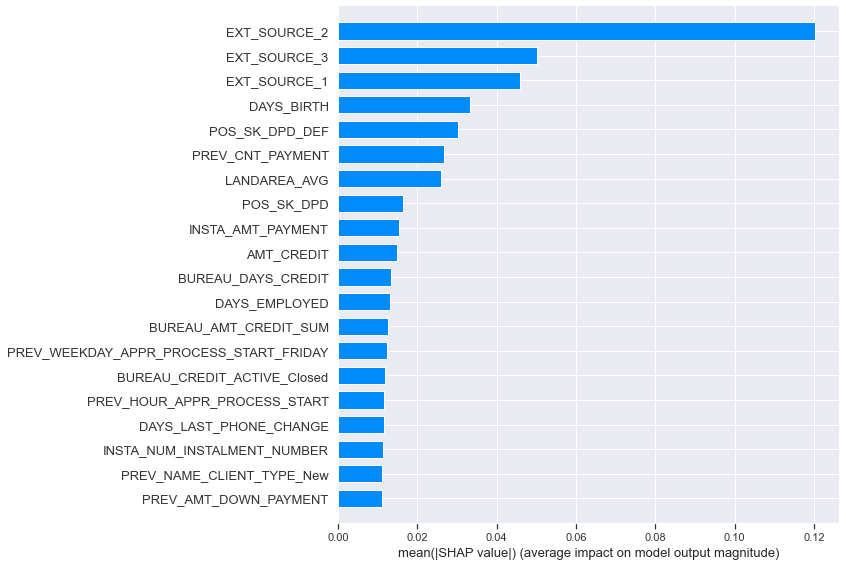

In [114]:
shap.summary_plot(shap_values, X_test_final[selected_features].loc[[226218]],plot_type='bar')

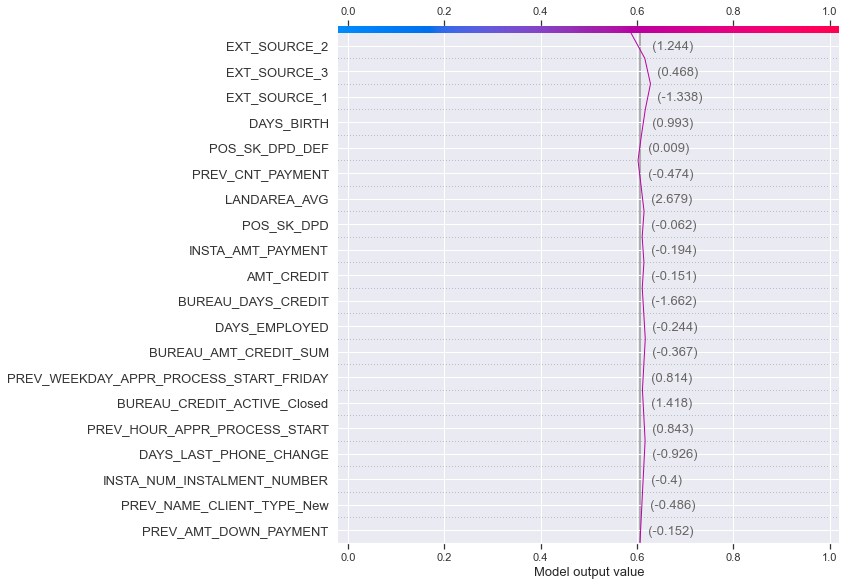

In [115]:
shap.decision_plot(
    base_value=lgbm_explainer.expected_value,
    shap_values=shap_values,
    features=X_test_final[selected_features].loc[[226218]],
    feature_names=X_test_final[selected_features].columns.tolist(),
    link="logit",
    #new_base_value=0.5
)

+ #### Prediction pour 100 clients

In [116]:
clients = 100
data_for_prediction = X_test_final[selected_features].iloc[0:clients ,:]  
clf1.predict_proba(data_for_prediction)

array([[0.1410923 , 0.8589077 ],
       [0.29852599, 0.70147401],
       [0.5614225 , 0.4385775 ],
       [0.64639731, 0.35360269],
       [0.19608812, 0.80391188],
       [0.24105228, 0.75894772],
       [0.74947609, 0.25052391],
       [0.8925013 , 0.1074987 ],
       [0.34262811, 0.65737189],
       [0.21542384, 0.78457616],
       [0.87941716, 0.12058284],
       [0.43438039, 0.56561961],
       [0.17732503, 0.82267497],
       [0.18236248, 0.81763752],
       [0.31865372, 0.68134628],
       [0.19251379, 0.80748621],
       [0.85105816, 0.14894184],
       [0.43021905, 0.56978095],
       [0.75154539, 0.24845461],
       [0.49896394, 0.50103606],
       [0.17634909, 0.82365091],
       [0.33665214, 0.66334786],
       [0.77988305, 0.22011695],
       [0.53206679, 0.46793321],
       [0.64981408, 0.35018592],
       [0.33708218, 0.66291782],
       [0.53003414, 0.46996586],
       [0.2107867 , 0.7892133 ],
       [0.84221676, 0.15778324],
       [0.23771141, 0.76228859],
       [0.

In [117]:
shap_values = lgbm_explainer.shap_values(data_for_prediction)
shap.force_plot(lgbm_explainer.expected_value, shap_values, data_for_prediction)

+ ### Statistique pour dashboard

In [118]:
df1=df.copy()

In [119]:
df1['AGE']=round(np.abs(df1['DAYS_BIRTH']/365)).astype(int)

In [120]:
df1.set_index('SK_ID_CURR',inplace=True)

In [121]:
df1['AGEC']=pd.cut(df1['AGE'],bins=[20, 33, 45, 57, 70])

In [122]:
average_hold=df1.groupby(['TARGET']).mean()

In [123]:
average_hold

CNT_CHILDREN  AMT_INCOME_TOTAL     AMT_CREDIT   AMT_ANNUITY  \
TARGET                                                                
0           0.412946     169077.722266  602648.282002  27163.623349   
1           0.463807     165611.760906  557778.527674  26481.744290   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE    DAYS_BIRTH  \
TARGET                                                              
0         542736.795003                    0.021021 -16138.176397   
1         488972.412554                    0.019131 -14884.828077   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
TARGET                                                                   
0        -2438.140133       -5029.941065     -3017.219788    11.935540   
1        -1814.918800       -4487.127009     -2732.099617    13.668691   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
TARGET                                                                  
0         0.999996        0.814653         0.195991          0.998129   
1         1.000000        0.879517         0.237825          0.998187   

        FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
TARGET                                                                  
0         0.284238    0.056840         2.150154              2.043578   
1         0.244955    0.055347         2.181269              2.153635   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
TARGET                                                         
0                          2.022449                12.086807   
1                          2.134824                11.797100   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
TARGET                                                           
0                         0.014942                    0.050317   
1                         0.017442                    0.055911   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
TARGET                                                        
0                          0.040494                0.074641   
1                          0.042538                0.118389   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
TARGET                                                                  
0                      0.22409                 0.175856      0.511461   
1                      0.30292                 0.221672      0.386968   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
TARGET                                                                 
0           0.523479      0.520969        0.118314          0.088952   
1           0.410935      0.390717        0.105766          0.081548   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
TARGET                                                                 
0                          0.977893         0.753153        0.045005   
1                          0.975634         0.743231        0.039444   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
TARGET                                                               
0            0.080194       0.150249       0.228023        0.23337   
1            0.062036       0.142707       0.203021        0.21196   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
TARGET                                                       
0           0.066575              0.101405        0.108400   
1           0.063108              0.092255        0.094096   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
TARGET                                                                
0                      0.008850           0.028615         0.115036   
1                      0.008252           0.024887         0.103463   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
TARGET                   

In [124]:
average_hold['AGE'].values[1]

40.77897280966767

In [125]:
average_hold['AGE'].iplot(kind="barh")

In [126]:
df1.loc[[426066]]

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
426066           0         Cash loans           F            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
426066                   Y             0          135000.0     82512.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
SK_ID_CURR                                                 
426066           3973.5          54000.0   Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
426066      Commercial associate  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
426066      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
426066                         0.02461      -10906        -2158.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
426066                -4487.0            -3188          NaN           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
426066                   1                0                 1           1   

            FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                                      
426066               0     Sales staff              1.0                     2   

            REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
SK_ID_CURR                                                           
426066                                2                     FRIDAY   

            HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                                                        
426066                           13                           0   

            REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                            
426066                               0                            0   

            REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
SK_ID_CURR                                                   
426066                           0                       0   

            LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
SK_ID_CURR                                                                  
426066                            0  Business Entity Type 3           NaN   

            EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
SK_ID_CURR                                                                 
426066          0.319644           NaN             NaN               NaN   

            YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
SK_ID_CURR                                                                 
426066                              NaN              NaN             NaN   

            ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
SK_ID_CURR                                                               
426066                NaN            NaN            NaN            NaN   

            LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
SK_ID_CURR                                                       
426066               NaN                   NaN             NaN   

            NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
SK_ID_CURR                                                                
426066                          NaN                NaN 

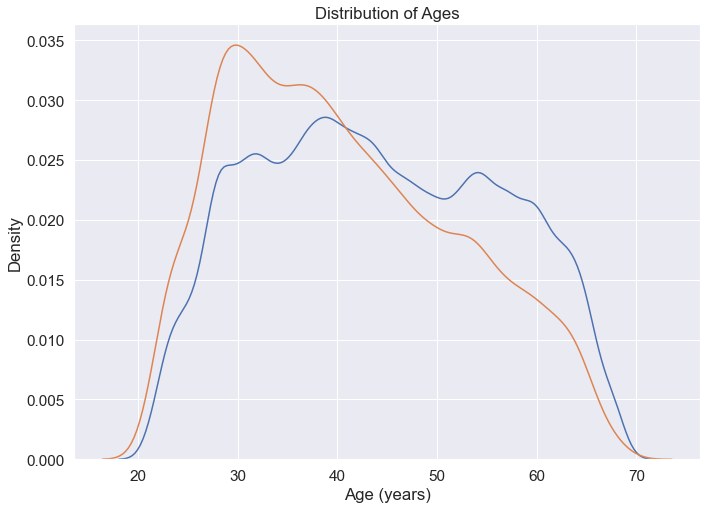

In [127]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df1.loc[df1['TARGET'] == 0, 'AGE'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df1.loc[df1['TARGET'] == 1, 'AGE'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)');
plt.ylabel('Density');
plt.title('Distribution of Ages');

In [128]:
# intialise data of lists. 
data = {'Name':['CLIENT', 'AVERAGE_CLIENT_REPAID', 'AVERAGE_CLIENT_NO_REPAID'], 
        'AGE':[df1.loc[426066].AGE, average_hold['AGE'].values[0],average_hold['AGE'].values[1]]} 
  
# Create DataFrame 
temp = pd.DataFrame(data) 
temp.set_index('Name',inplace=True)
temp.iplot(kind='bar', labels=temp.index, values=temp.AGE,
         title='Le client compare à la moyenne')